# Predict direct marketing campaign successfully using UC bank marketing dataset

oleh: Irham Najmudin

## Introduction

term deposite atau deposito berjangka adalah produk bank sejenis tabungan, dimana uang yang disetorkan dalam deposito berjangka tidak boleh ditarik nasabah dan baru bisa dicairkan sesuai dengan tanggal jatuh temponya. Ada beberapa jangka waktu yang bisa dipilih, yaitu 1, 3, 6, 12, atau 24 bulan. Namun, bila deposito dicairkan sebelum tanggal jatuh tempo, maka akan kena penalti. lebih lengkapnya bisa melihat: https://www.cekaja.com/deposito-berjangka

Pada kasus ini kita diberikan data berupa data client, data  marketing campaign yang dilakukan oleh bank sebelumnya serta data lain berupa data ekonomi dan sosial untuk memprediksi apakah client akan cenderung subscribe term deposite dimasa depan dengan kondisi yang diberikan oleh data.

## Attribute Information

Adapun atribut atau informasi dari setiap column adalah sebagai berikut

**Input variables:**
**bank client data:**
1. age (numeric)
1. job : tipe pekerjaan (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : Status pernikahan (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. Education : Status pendidikan (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: apakah client memiliki kredit? (categorical: 'no','yes','unknown')
6. housing: apakah client mempunyai pinjaman rumah? (categorical: 'no','yes','unknown')
7. loan: apakah client mempunyai pinjaman atau hutang? (categorical: 'no','yes','unknown')

**terkait contak terakhir yang dilakukan terhadap client di saat campaign:**
8. contact: jenis komunikasi ketika mengontak client (categorical: 'cellular','telephone')
9. month: bulan terakhir dilakukan contact ke client (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: hari terakhir contak dengan client dilakukan (categorical: 'mon','tue','wed','thu','fri')
11.  duration: durasi kontak dengan client dalam detik(numeric). 

**atribut yang lain:**
12. campaign: jumlah contact yang dilakukan dengan client selama campaign
13. pdays: jumlah hari yang telah terlewati sejak hari terakhir dilakukan contact dengan client (numeric; 999 berarti client tidak dicontact atau dihubungi selama campaign)
14.  previous: jumlah contact yang dilakukan terhadap client sebelum campaign
15. poutcome: hasil dari marketing campaign sebelumnya (categorical: 'failure','nonexistent','success')

**sosial dan ekonomi** 
16.  emp.var.rate: employment variation rate - quarterly indicator (numeric)
17.  cons.price.idx: consumer price index - monthly indicator (numeric)
18.  cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19.  euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: jumlah employee - quarterly indicator (numeric)

**Output variable (desired target):**
21.  y - apakah client subscribe term deposite? (binary: 'yes','no')



## General Information of Data

#### Instal Library

In [1]:

!pip install pyspark

import pandas as pd
import numpy as np

#pipeline
from pyspark.ml import Pipeline

#chi square test
from pyspark.ml.stat import ChiSquareTest

#point biserial
from scipy import stats

#pyspark type
from pyspark.sql.types import IntegerType

#pyspark.sql function
from pyspark.sql import functions as F

#One hot encoding
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler


#normalization
from pyspark.ml.feature import Normalizer

from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier

#ensemble classification
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier

#SVM
from pyspark.ml.classification import LinearSVC

#NaiveBayes
from pyspark.ml.classification import NaiveBayes

#evaluation
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.types import IntegerType, DoubleType
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix


#visualization 
import matplotlib.pyplot as plt
import seaborn as sns

     |████████████████████████████████| 204.2MB 72kB/s 
     |████████████████████████████████| 204kB 49.8MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=68056e65917106c67b30dae9181676da5f5982c4908526422dced080f6ec8d2d
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


### Read dataset

Sebelum kita memasukkan data ke dalam sebuah "DataFrame" spark, kita perlu membuat konfigurasi SparkSession. Konfigurasi ini sama seperti ketika kita login ke suatu aplikasi, kita tentunya akan membuat sebuah session yang mengakses aplikasi tersebut. Nah pada spark kita menggunakan Spark Session untuk mengakses suatu Spark Context tertentu misal memanggil fungsi spark.read.csv untuk membaca dataset berformat csv.

In [2]:
from pyspark.sql import SparkSession

#membuat SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()

#read dataset
bank_marketing = spark.read.csv('drive/My Drive/bank-additional-full.csv',sep=';', header=True, inferSchema=True)

Selanjutnya, prrintSchema untuk melihat informasi column dalam dataset bank_marketing

In [3]:
bank_marketing.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



nullable = True pada PrintSchema menunjukkan apakah column tertentu pada pyspark dataframe boleh memiliki missing value atau tidak. jika suatu column memiliki nullable = False, maka akan muncul error ketika mengeksekusi kode pada column yang memiliki missing value (karena nullable=False, column tidak boleh memiliki missing value). Ketika nullable = True, maka error tidak akan muncul pada column yang memiliki missing value (karena nullable=True, column boleh memiliki missing value)

In [4]:
text_type_columns = [col[0] for col in bank_marketing.dtypes if col[1].startswith('string')]
numeric_type_columns = [col[0] for col in bank_marketing.dtypes if col[1] != 'string']

print('total_text_type_columns {}'.format(len(text_type_columns)))
print('total_numeric_type_columns {}'.format(len(numeric_type_columns)))

total_text_type_columns 11
total_numeric_type_columns 10


dari data columns diatas, dapat diketahui bahwa data memiliki columns berjenis numeric = 10, dan column berjenis text = 11, dengan y adalah target columns berjenis string


bentuk pyspark dataframe adalah sebagai berikut

In [5]:
bank_marketing.show(10)

+---+-----------+-------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|        job|marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+-----------+-------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|  housemaid|married|           basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57|   services|married|        high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994| 

In [6]:
bank_marketing.head(10)

[Row(age=56, job='housemaid', marital='married', education='basic.4y', default='no', housing='no', loan='no', contact='telephone', month='may', day_of_week='mon', duration=261, campaign=1, pdays=999, previous=0, poutcome='nonexistent', emp.var.rate=1.1, cons.price.idx=93.994, cons.conf.idx=-36.4, euribor3m=4.857, nr.employed=5191.0, y='no'),
 Row(age=57, job='services', marital='married', education='high.school', default='unknown', housing='no', loan='no', contact='telephone', month='may', day_of_week='mon', duration=149, campaign=1, pdays=999, previous=0, poutcome='nonexistent', emp.var.rate=1.1, cons.price.idx=93.994, cons.conf.idx=-36.4, euribor3m=4.857, nr.employed=5191.0, y='no'),
 Row(age=37, job='services', marital='married', education='high.school', default='no', housing='yes', loan='no', contact='telephone', month='may', day_of_week='mon', duration=226, campaign=1, pdays=999, previous=0, poutcome='nonexistent', emp.var.rate=1.1, cons.price.idx=93.994, cons.conf.idx=-36.4, euri

In [7]:
import pandas as pd
pd.DataFrame(bank_marketing.take(10), columns = bank_marketing.columns).transpose()

,0,1,2,3,4,5,6,7,8,9
age,56,57,37,40,56,45,59,41,24,25
job,housemaid,services,services,admin.,services,services,admin.,blue-collar,technician,services
marital,married,married,married,married,married,married,married,married,single,single
education,basic.4y,high.school,high.school,basic.6y,high.school,basic.9y,professional.course,unknown,professional.course,high.school
default,no,unknown,no,no,no,unknown,no,unknown,no,no
housing,no,no,yes,no,no,no,no,no,yes,yes
loan,no,no,no,no,yes,no,no,no,no,no
contact,telephone,telephone,telephone,telephone,telephone,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon,mon,mon,mon,mon,mon


### Statistical Summary from data

statistical summary dari data bank_marketing adalah sebagai berikut

In [8]:
bank_marketing.describe().show()

+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+------------------+------------------+-----------------+-------------------+--------+-------------------+------------------+------------------+------------------+-----------------+-----+
|summary|               age|    job| marital|education|default|housing| loan|  contact|month|day_of_week|          duration|          campaign|            pdays|           previous|poutcome|       emp.var.rate|    cons.price.idx|     cons.conf.idx|         euribor3m|      nr.employed|    y|
+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+------------------+------------------+-----------------+-------------------+--------+-------------------+------------------+------------------+------------------+-----------------+-----+
|  count|             41188|  41188|   41188|    41188|  41188|  41188|41188|    41188|41188|      41188|             41188|

Secara keseluruhan kita mendapatkan 

### check missing values

beberapa nama columns memiliki huruf tambahan seperti '.' yang mengakibatkan error ketika melakukan eksekusi code atau perubahan data pada columns tersebut. untuk mengatasinya maka nama columns yang memiliki '.' akan dirubah ke '_'

In [9]:
#change columns name
from functools import reduce

#ambil nama columns bank_marketing
old_columns = bank_marketing.schema.names

#rubah columns dengan menggunakan replace
new_columns = list(col.replace('.','_') for col in old_columns)

#rubah semua columns menggunakan fungsi reduce
bank_marketing = reduce(lambda bank_marketing,
                        idx: bank_marketing.withColumnRenamed(old_columns[idx],
                                                              new_columns[idx]),
                        range(len(old_columns)), bank_marketing)



In [10]:
#check perubahan
bank_marketing.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



In [11]:
from pyspark.sql.functions import when, count, col

#check null values
check_null = bank_marketing.select([count(when(col(c).isNull(), c)).alias(c) for c in bank_marketing.columns]).show()
check_null

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|  0|  0|      0|        0|      0|      0|   0|      0|    0|          0|       0|       0|    0|       0|       0|           0|             0|            0|        0|          0|  0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+



ternyata datanya tidak memiliki missing values.

selanjutnya, cek data kembali untuk melihat apakah missing values tersebut dirubah dalam bentuk yang lain

In [12]:
bank_marketing.groupby('age').count().show()

+---+-----+
|age|count|
+---+-----+
| 31| 1947|
| 85|   15|
| 65|   44|
| 53|  733|
| 78|   27|
| 34| 1745|
| 81|   20|
| 28| 1001|
| 76|   34|
| 27|  851|
| 26|  698|
| 44| 1011|
| 91|    2|
| 22|  137|
| 47|  928|
| 52|  779|
| 86|    8|
| 40| 1161|
| 20|   65|
| 94|    1|
+---+-----+
only showing top 20 rows



In [13]:
bank_marketing.groupby('education').count().show()

+-------------------+-----+
|          education|count|
+-------------------+-----+
|        high.school| 9515|
|            unknown| 1731|
|           basic.6y| 2292|
|professional.course| 5243|
|  university.degree|12168|
|         illiterate|   18|
|           basic.4y| 4176|
|           basic.9y| 6045|
+-------------------+-----+



In [14]:
bank_marketing.groupby('job').count().show()

+-------------+-----+
|          job|count|
+-------------+-----+
|   management| 2924|
|      retired| 1720|
|      unknown|  330|
|self-employed| 1421|
|      student|  875|
|  blue-collar| 9254|
| entrepreneur| 1456|
|       admin.|10422|
|   technician| 6743|
|     services| 3969|
|    housemaid| 1060|
|   unemployed| 1014|
+-------------+-----+



ternyata beberapa missing values tersebut dirubah menjadi 'unknown' sehingga untuk melihat berapa jumlah missing values kita bisa dengan menghitung jumlah row yang memiliki nilai 'unknown'

In [15]:
check_unknown = bank_marketing.select([count(when(col(c) == 'unknown', c)).alias(c) for c in bank_marketing.columns]).toPandas().T
check_unknown = check_unknown.reset_index()
check_unknown.columns = ['name_col', 'total_null']
check_unknown = check_unknown[check_unknown['total_null'] !=0].sort_values('total_null', ascending=False)
check_unknown['percent_null'] =(check_unknown['total_null'] / bank_marketing.count()) * 100
check_unknown


,name_col,total_null,percent_null
4,default,8597,20.872584
3,education,1731,4.202680
5,housing,990,2.403613
6,loan,990,2.403613
1,job,330,0.801204
2,marital,80,0.194231


dari data diatas dapat diketahui bahwa default memiliki nilai missing value tertinggi, yaitu sekitar 20 %  dri total data, sedangkan strategi untuk mengatasi missing values tersebut akan dilakukan setelah melakukan EDa

### Check Duplicated

pada dasarnya pyspark tidak memiliki fungsi khusus untuk check duplikasi dalam suatu data, untuk mengakalinya, kita bisa melakukan perbandingan. salah satunya membandingkan jumlah data keseluruhan dengan jumlah keseluruhan unique value di data tersebut.(dikatakan unique value apabila minimal salah satu data column dalam suatu row berbeda dengan data di row yang lain ) (data akan dikatakan terduplikasi apabila seluruh data dalam satu row muncul dalam row yang lain)

In [16]:
print(bank_marketing.count())
print(bank_marketing.distinct().count())
if bank_marketing.count() > bank_marketing.distinct().count():
  print('data has duplicates')
else:
  print('no duplicate')

41188
41176
data has duplicates


ternyata data terduplikasi, untuk melihatnya kita bisa  mengroub data berdasarkan new_columns dalam membuat satu columns lagi berupa jumlah row tersebut. jika count = 1 maka data terduplikasi

In [17]:
#get duplicated row
df_duplicated = bank_marketing.groupby(new_columns).count()

df_duplicated.filter("count != 1").show()

+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+-----+
|age|        job| marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|count|
+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+-----+
| 55|   services| married|        high.school|unknown|     no|  no| cellular|  aug|        mon|      33|       1|  999|       0|nonexistent|         1.4|        93.444|        -36.1|    4.965|     5228.1| no|    2|
| 24|   services|  single|        high.school|     no|    yes|  no| cellular|  apr|        tue|     114|       1|  999|       0|nonexistent|

karena jumlah data tidak terlalu banyak, maka kita bisa mendrop data yang terduplikasi dan hanya menyisakan satu data saja

In [18]:
#drop duplicates
bank_marketing = bank_marketing.dropDuplicates()
bank_marketing.count()

41176

##Univariate Analysis

In [19]:
text_columns = [col[0] for col in bank_marketing.dtypes if col[1].startswith('string')]
numeric_columns = [col[0] for col in bank_marketing.dtypes if col[1] != 'string']

### Numeric columns

fungsi describe pada pyspark tidak menunjukkan nilai percentile dari column numerik, untuk mengakalinya kita bisa buat fungsi describe baru yang dapat menunjukkan nilai 3 quartile

In [20]:
def describes(data, columns):
  percentiles = np.transpose([np.percentile(data.select(x).collect(), [25,50,75]) for x in columns])
  percentiles = pd.DataFrame(percentiles, columns=columns)
  percentiles['summary'] = [str(p) + ' %' for p in [25,50,75]]

  df_describes = data.describe().toPandas()
  spark_describe = pd.concat([df_describes, percentiles], ignore_index=True)
  spark_describe = spark_describe.round(2)
  
  return spark_describe[['summary'] + columns]


lalu kita bisa buat definisi lagi untuk memplot data bersama dengan nilai skewness dan kurtosis agar kita dapat melihat juga nilai ketidaknormalan dari column numerik

In [21]:

def to_hist(datas, columns):
  new_df = datas.select(columns).toPandas()

  skewkur = datas.select(F.skewness(columns), F.kurtosis(columns)).show()

  plt.figure(figsize=(15,7))
  fig = sns.distplot(new_df[columns])

  fig.set_title(columns, size=20)
  fig.set_ylabel('distance', size=10)
  fig.set_xlabel(columns, size=10)

  return skewkur, fig



#### Age

+------------------+------------------+
|     skewness(age)|     kurtosis(age)|
+------------------+------------------+
|0.7845316793906341|0.7908715485573281|
+------------------+------------------+



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(None, <matplotlib.axes._subplots.AxesSubplot at 0x7fcffbb5d6a0>)

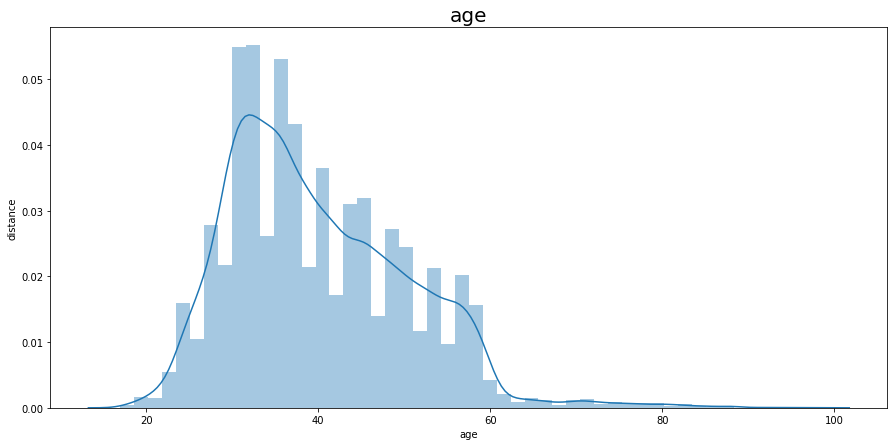

In [22]:
to_hist(bank_marketing, 'age')

dari grafik diatas, dapat diketahui bahwa data ages memiliki kondisi 'left skeewed', sedangkan dari informasi kurtosis kita bisa mengetahui bahwa dengan nilai kurtosis positive dibawah 1, berarti data cenderung tidak homogen (diperkuat dengan visualisasi yang mayotitas data terkumpul mulai umur 25 - 50). untuk selengkapnya kita bisa lihat summary statistik dibawah

In [23]:
describes(bank_marketing, ['age'])

,summary,age
0,count,41176
1,mean,40.02380027200311
2,stddev,10.420679868942722
3,min,17
4,max,98
5,25 %,32
6,50 %,38
7,75 %,47


ternyata data terendahnya berada diposisi umur 17 tahun, hal ini tentu berbeda dengan deskripsi columns, dimana data seharusnya diatas 17 tahun. selanjutnya, check jumlah data dibawah 18 tahun

In [24]:
bank_marketing.filter(bank_marketing.age < 18).show()

+---+-------+-------+---------+-------+-------+-------+--------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|age|    job|marital|education|default|housing|   loan| contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+-------+-------+---------+-------+-------+-------+--------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
| 17|student| single|  unknown|     no|    yes|     no|cellular|  aug|        wed|     432|       3|    4|       2| success|        -2.9|        92.201|        -31.4|    0.884|     5076.2| no|
| 17|student| single| basic.9y|     no|    yes|     no|cellular|  aug|        fri|     182|       2|  999|       2| failure|        -2.9|        92.201|        -31.4|    0.869|     5076.2| no|
| 17|student| single| basic.9y|    

ternyata hanya 5 data yang memiliki umur 17 tahun, untuk mengatasinya kita bisa menghapus atau merubah data di column 17 tahun. namun dengan perbandingan total jumlah data yang +- 41 ribu, menghapus lima data tidak akan mengubah secara keseluruhan kondisi data sendiri, sehingga dalam feature engineering kita bisa menghapusnya

#### Duration

+------------------+------------------+
|skewness(duration)|kurtosis(duration)|
+------------------+------------------+
|3.2626886475170997|20.241167105999782|
+------------------+------------------+



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(None, <matplotlib.axes._subplots.AxesSubplot at 0x7fcffa7e4860>)

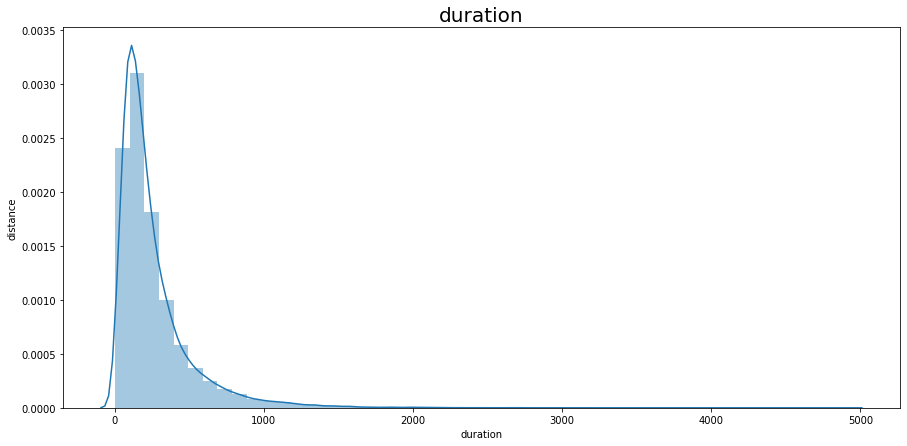

In [25]:
to_hist(bank_marketing, 'duration')

terlihat jelas bahwa skewness pada column duration jauh lebih tinggi daripada column age yang mana mengakibatkan nilai kurtosisnya sangat tinggi(data cenderung homogen dan memiliki variance atau persebaran yang rendah). selain itu kita bisa melihat bahwa ada beberapa data yang memiliki nilai dibawah 1. 

In [26]:
bank_marketing.filter(bank_marketing.duration <= 0).select(['duration','y']).show()

+--------+---+
|duration|  y|
+--------+---+
|       0| no|
|       0| no|
|       0| no|
|       0| no|
+--------+---+



dalam deskripsi data UC bank marketing diketahui bahwa jika durasi = 0 maka y = no, jadi jika terdapat durasi = 0 namun y = yes, data harus dirubah menjadi no. karena pada data diatas tidak ditemukan kesalahan (durasi = 0, y = yes) maka data tidak perlu dirubah

#### Campaign

+------------------+------------------+
|skewness(campaign)|kurtosis(campaign)|
+------------------+------------------+
|4.7618705829174965| 36.96722235388963|
+------------------+------------------+



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(None, <matplotlib.axes._subplots.AxesSubplot at 0x7fcff7a73588>)

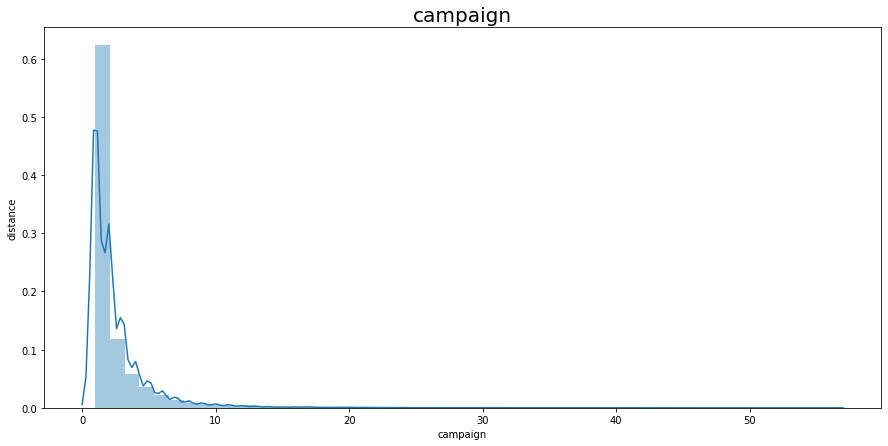

In [27]:
to_hist(bank_marketing, 'campaign')

menariknya, data diatas memiliki kondisi skewness yang juga lebih tinggi dari data duration serta memiliki nilai persebaran lebih rendah dari data durasi (dapat dilihat dari nilai positif kurtosis dan visualisasi yang cenderung jumlah data berada dibawah 10). untuk melihat lebih lengkap, kita bisa melihat melalui deskripsi

In [28]:
campaign_describe = describes(bank_marketing, ['campaign']).set_index('summary').T
campaign_describe

summary,count,mean,stddev,min,max,25 %,50 %,75 %
campaign,41176,2.567879347192539,2.770318336377937,1,56,1,2,3


mayoritas data memiliki nilai 1 dan 2, untuk selanjutnya kita bisa melihat berapa jumlah data yang berada diposisi outlier

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


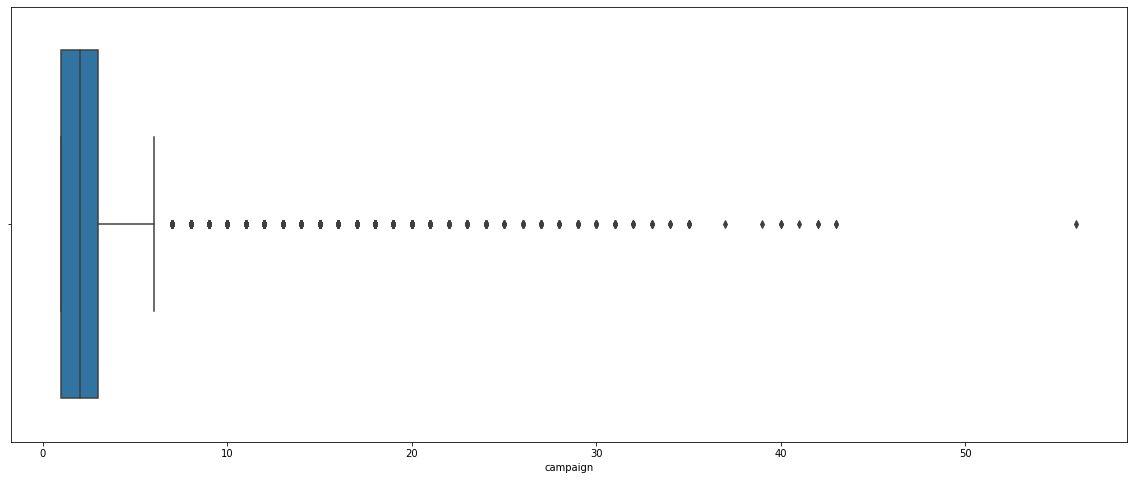

In [29]:
fig = plt.figure(figsize=(20, 8))

df_campaign = bank_marketing.select('campaign').toPandas()
ax = sns.boxplot(df_campaign['campaign'])

In [30]:
IQR = campaign_describe.loc['campaign','75 %'] - campaign_describe.loc['campaign','25 %']
outliers = campaign_describe.loc['campaign','75 %'] + 1.5*IQR

total_outliers = bank_marketing.filter(bank_marketing.campaign > outliers).count() 
percent_outliers = bank_marketing.filter(bank_marketing.campaign > outliers).count() / bank_marketing.select('campaign').count()

print('total_outliers: {}'.format(total_outliers))
print('percent_outliers: {}'.format(percent_outliers))

total_outliers: 2406
percent_outliers: 0.05843209636681562


column campaign bisa memberikan informasi berharga mengenai suksesnya campaign yang dilakukan oleh bank. sedangkan pada data diatas, dengan menggunakan 1.5 * IQR didapatkan 240 outliers. untuk menentukan apakah kita perlu menghapus atau mengganti nilainya kita bisa melihat distribusi nya berdasarkan data targetnya(column y)

In [31]:
bank_marketing.filter(F.col('campaign') > outliers).groupby('y').count().show()

+---+-----+
|  y|count|
+---+-----+
| no| 2295|
|yes|  111|
+---+-----+



untuk data dengan nilai sama dengan outliers

In [32]:
bank_marketing.filter(F.col('campaign') == outliers).groupby('y').count().show()

+---+-----+
|  y|count|
+---+-----+
| no|  904|
|yes|   75|
+---+-----+



terlihat kedua data diatas memeiliki pattern yang sama, yaitu jumlah value 'no' jauh lebih banyak daripada 'yes', sehingga untuk data engineering kita bisa merubah data diatas outliers dengan value batas outliers (quartile(75 %) + 1.5*IQR)

#### Pdays

+------------------+----------------+
|   skewness(pdays)| kurtosis(pdays)|
+------------------+----------------+
|-4.921207099141229|22.2187088066418|
+------------------+----------------+



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(None, <matplotlib.axes._subplots.AxesSubplot at 0x7fcff788b6d8>)

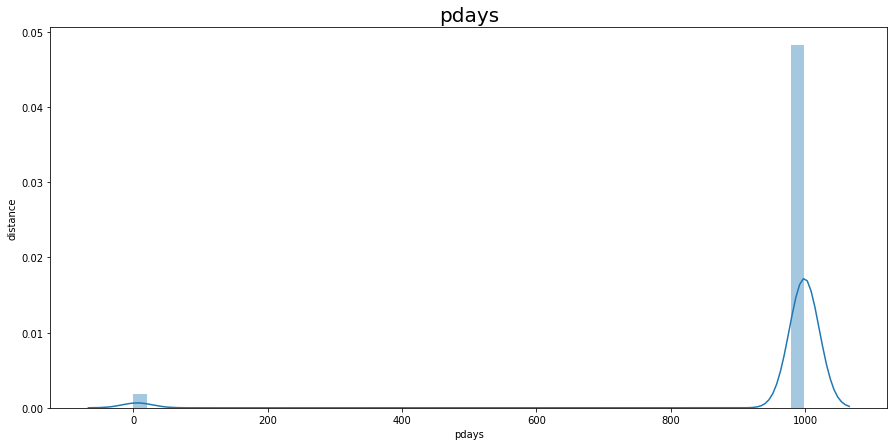

In [33]:
to_hist(bank_marketing, 'pdays')

kelihatannya banyak data yang berada di sekitar nilai 100

In [34]:
bank_marketing.filter(F.col('pdays') == 999).count() / bank_marketing.count()

0.9632067223625412

96 persen data memiliki nilai 999, hal ini akan membuat algoritma machine learning kehilangan akurasinya sehingga lebih baik columnya dihapus

#### previous

+------------------+------------------+
|skewness(previous)|kurtosis(previous)|
+------------------+------------------+
|  3.83125593884973| 20.09957712427588|
+------------------+------------------+



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(None, <matplotlib.axes._subplots.AxesSubplot at 0x7fcff777f6a0>)

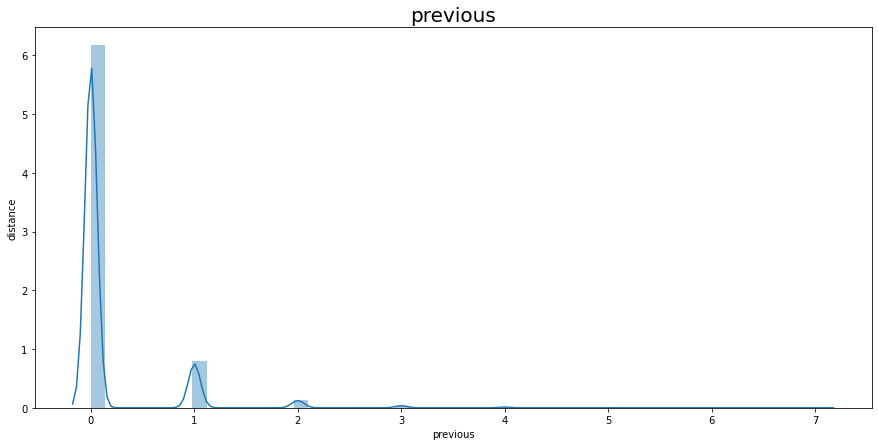

In [35]:
to_hist(bank_marketing, 'previous')

kehihatnnya previous memiliki pattern yang sama dengan pdays

In [36]:
bank_marketing.filter(F.col('previous') == 0).count() / bank_marketing.count()

0.8633912959005245

sama seperti pdays, lebih baik columnya dihapus

#### Social and Economic Indicator

+----------------------+----------------------+
|skewness(emp_var_rate)|kurtosis(emp_var_rate)|
+----------------------+----------------------+
|   -0.7240342146771622|   -1.0627146973656139|
+----------------------+----------------------+



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


+------------------------+------------------------+
|skewness(cons_price_idx)|kurtosis(cons_price_idx)|
+------------------------+------------------------+
|    -0.23084449694406914|     -0.8298960161833224|
+------------------------+------------------------+



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


+-----------------------+-----------------------+
|skewness(cons_conf_idx)|kurtosis(cons_conf_idx)|
+-----------------------+-----------------------+
|    0.30286496655150286|    -0.3591991612497831|
+-----------------------+-----------------------+



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


+-------------------+-------------------+
|skewness(euribor3m)|kurtosis(euribor3m)|
+-------------------+-------------------+
|-0.7091683770703314|-1.4067662115952226|
+-------------------+-------------------+



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


+---------------------+---------------------+
|skewness(nr_employed)|kurtosis(nr_employed)|
+---------------------+---------------------+
|  -1.0442790133772502| -0.00368495268979...|
+---------------------+---------------------+



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


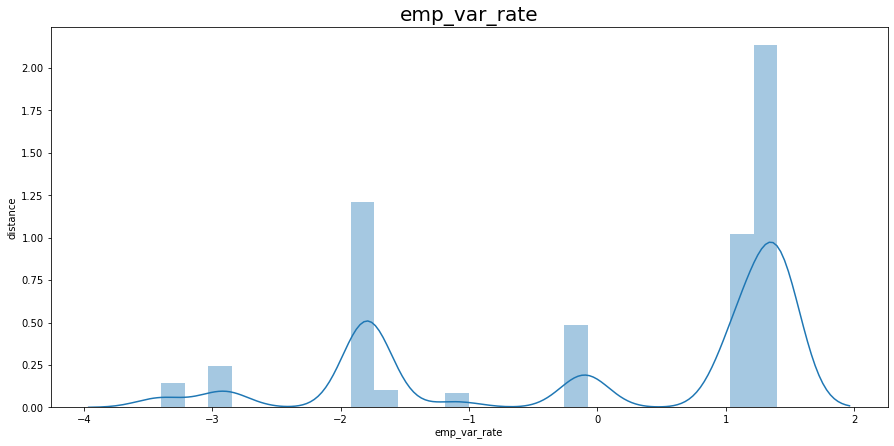

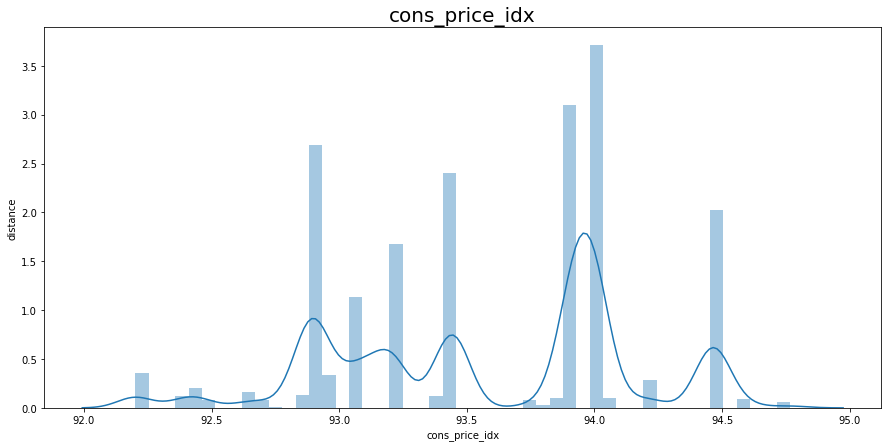

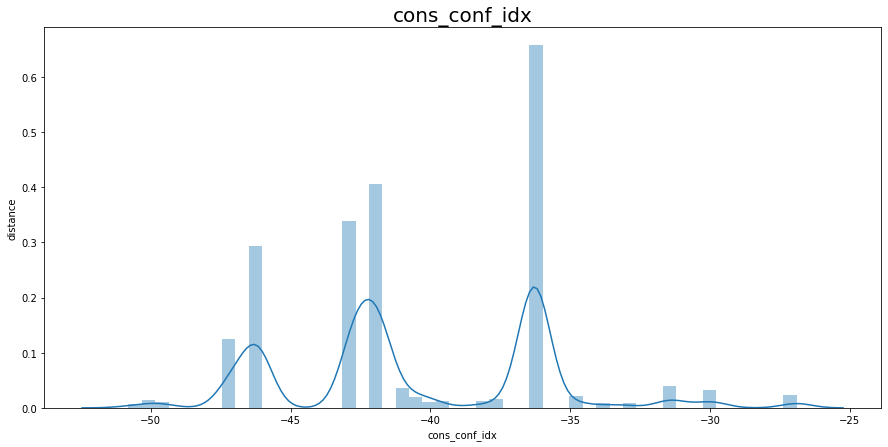

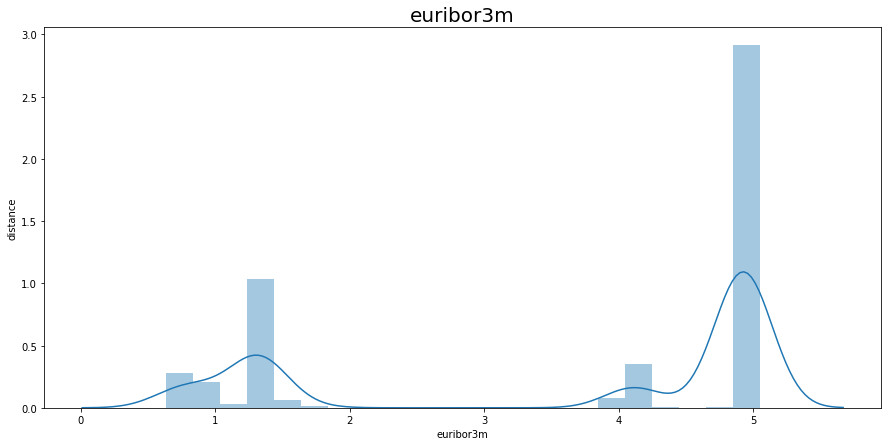

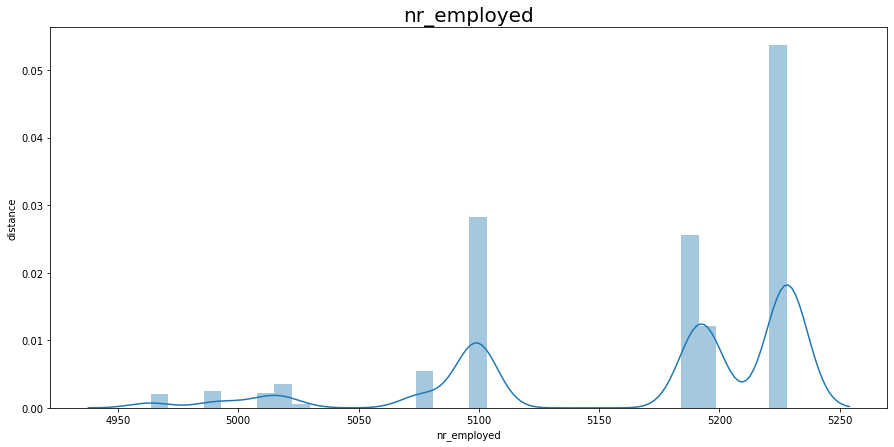

In [37]:
for c in ['emp_var_rate','cons_price_idx','cons_conf_idx','euribor3m','nr_employed']:
  to_hist(bank_marketing, c)

data pada indikator sosial dan ekonomi memiliki distribusi yang cenderung normal, namun untuk lengkapnya kita harus mengivestigasinya menggunakan multivariate analysis

### Categorical Columns

#### Quick Overview

In [38]:
df_overview = bank_marketing.select(text_columns).toPandas()
overview = df_overview.describe().T.reset_index()

def list_unique(columns):
  l_unique = list(df_overview[columns].unique())
  return l_unique

def has_unknown(list_data):
  for x in list_data:
    if x == 'unknown':
      return True
  
  return False

overview['list_unique'] = overview['index'].apply(list_unique)
overview['has_unknown?'] = overview['list_unique'].apply(has_unknown)
overview['percent_freq'] = (overview['freq'] / overview['count']) *100
overview.sort_values(by=['percent_freq'], ascending=False)

,index,count,unique,top,freq,list_unique,has_unknown?,percent_freq
10,y,41176,2,no,36537,"[no, yes]",False,88.7337
9,poutcome,41176,3,nonexistent,35551,"[nonexistent, failure, success]",False,86.3391
5,loan,41176,3,no,33938,"[yes, no, unknown]",True,82.4218
3,default,41176,3,no,32577,"[no, unknown, yes]",True,79.1165
6,contact,41176,2,cellular,26135,"[telephone, cellular]",False,63.4714
1,marital,41176,4,married,24921,"[married, single, divorced, unknown]",True,60.5231
4,housing,41176,3,yes,21571,"[no, yes, unknown]",True,52.3873
7,month,41176,10,may,13767,"[may, jun, jul, aug, nov, apr, sep, oct, dec, ...",False,33.4345
2,education,41176,8,university.degree,12164,"[university.degree, high.school, basic.6y, bas...",True,29.5415
0,job,41176,12,admin.,10419,"[admin., blue-collar, management, services, te...",True,25.3036


dari data diatas kita mendapatkan beberapa informasi antara lain:

1. column y yang merupakan column target memiliki kondisi imbalance yang menunjukkan perlunya strategi tertentu ketika melakukan klasifikasi.
2. ada beberapa features yang menunjukkan kondisi imbalance misal poutcome dan loan yang memiliki value, dimana jumlah valuenya lebih dari 80 % dari total data. Dalam klasifikasi features yang imbalance cenderung memiliki korelasi yang rendah dengan target, maka perlu adanya identifikasi lebih lanjut
3. beberapa columns juga memiliki value unknown yang menunjukkan datanya memiliki missing value (job, education, loan, default, marital, housing) dan 4 diantaranya memiliki jumlah value yang memenuhi lebih dari 50 % dari total data
4. 2 columns diantaranya merupakan column time_series (month, day of week)


untuk lebih lengkapnya kita bisa melakukan bar plot untuk melihat lebih jelas mengenai kondisi setiap column

####Distirubution columns




In [39]:
new_df = bank_marketing.select('month').toPandas()

df_count = new_df['month'].value_counts(normalize=True).reset_index()
df_count.columns = ['month', 'total_count']
df_count['total_count'] = df_count['total_count']*100
df_count['total_count'] = df_count['total_count'].round(2)


#ordered the month
ordered_months = ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

df_count.loc[:,'month'] = pd.Categorical(df_count.loc[:,'month'], categories=ordered_months)
df_count

,month,total_count
0,may,33.43
1,jul,17.41
2,aug,15.00
3,jun,12.92
4,nov,9.96
5,apr,6.39
6,oct,1.74
7,sep,1.38
8,mar,1.33
9,dec,0.44


In [40]:
# for non time series
def plot_bar(datas, columns, order_value = []):
  new_df = datas.select(columns).toPandas()

  df_count = new_df[columns].value_counts(normalize=True).reset_index()
  df_count.columns = [columns, 'total_count']
  df_count['total_count'] = df_count['total_count']*100
  df_count['total_count'] = df_count['total_count'].round(2)


  #plot the data
  plt.figure(figsize=(15, 6))
  if order_value == []:
    ax = sns.barplot(x = columns,
                   y="total_count",
                   data=df_count)
    
  else:
    ax = sns.barplot(x = columns,
                   y="total_count",
                   data=df_count,
                   order = order_value)
  
  plt.title("total count " + columns, fontsize=17)
  plt.xlabel(columns, fontsize=16)
  plt.ylabel("count", fontsize=16)

  for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            height, 
            horizontalalignment='center', 
            verticalalignment='top')

  for bar in ax.patches:
      if bar.get_height() == df_count['total_count'].max():
          bar.set_color('red')    
      else:
          bar.set_color('grey')

  return ax

#### Distribution below 50 %

##### categorical (no time_series)

In [41]:
overview_below_50percent = overview[overview['percent_freq'] < 50]
columns_below50 = list(overview_below_50percent['index'])
columns_below50

['job', 'education', 'month', 'day_of_week']

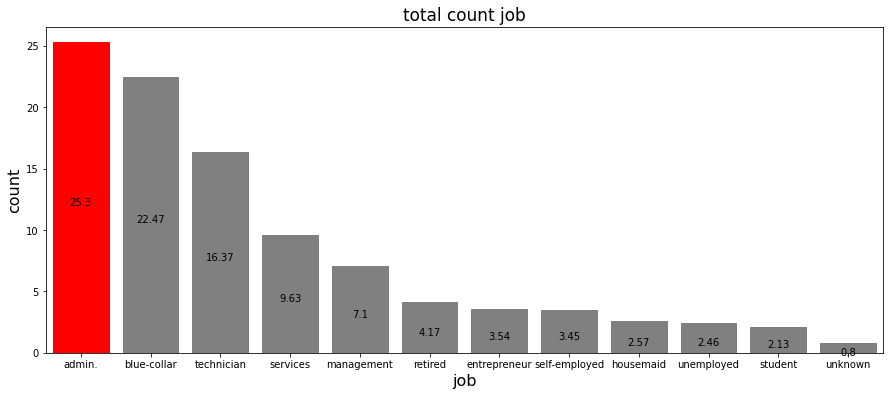

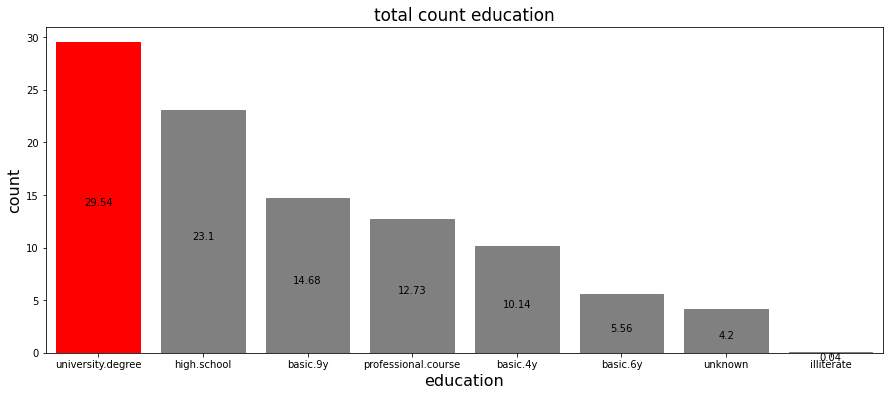

In [42]:
for col in ['job','education']:
  plot_bar(bank_marketing, col)

In [43]:
bank_marketing.filter(F.col('job') == 'unknown').count()

330

beberapa hal yang kita dapat:
1. Di kolom job, 25 % dari total customer bekerja sebagai admin atau administrator diikuti dengan pekerjaan sebagai blue-collar(pekerja lapangan misal tukang bangunan) dengan 22 %
2. kolom job juga menunjukkan sepertempat customer kita berasal dari pekerja kantoran (administrator ) sedangkan 22% berasal dari pekerja lapangan, sisanya merupakan teknisi, service (misal call center maupun pramusiaga) dll, sedankan 0.8 persen tidak dikethui,
3. Dalam kolom edukasi, 29 % dari total kustomer merupakan lulusan perguruan tinggi, diikuti dengan lulusan  SMA .
4. Menariknya, jumlah customer yang mempunyai latar belakang professional course lebih rendah dari pada lulusan SMP(basic.9 years), mungkin hal ini terkait dengan column lain misal pekerjaan. 

##### categorical (time series)

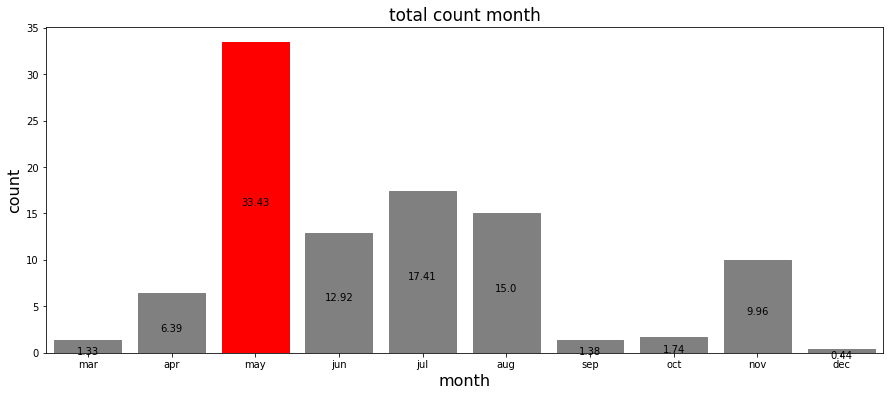

In [44]:
ordered_month = ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
ordered_day = ['mon','tue','wed','thu','fri']


#month

plot_bar(bank_marketing,'month', ordered_month)

last_contact yang dilakukan client terhadap UC bank mayoritas berasal dari bulan mei (33 % dari total data) sedangkan bulan yang lain hanya berada dibawah 20 %. Hal ini menarik untuk dicari penyebab mengapa last contact banyak terjadi di bulan mei, dan apakah dia berpengaruh ke feature lain, terutama column target

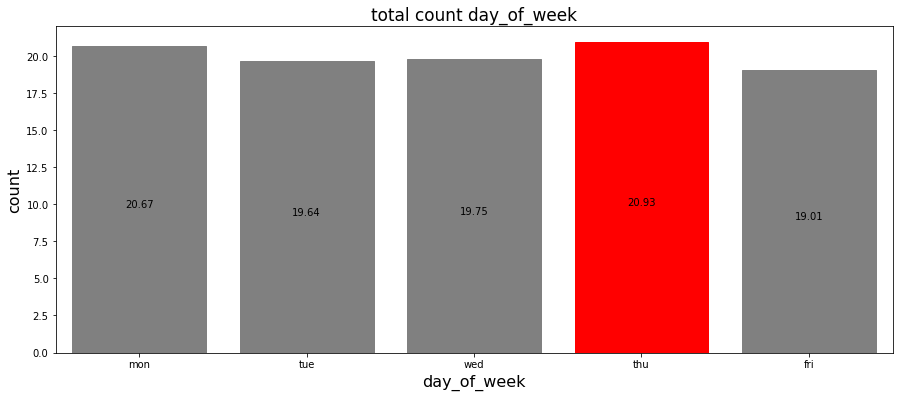

In [45]:
plot_bar(bank_marketing, 'day_of_week', ordered_day)

kita tidak mendapatkan terlalu banyak di column ini, hal ini karena data setiap hari memiliki jumlah proporsi yang hampir sama

#### Distribution in Inbalance features

In [46]:
overview_more_50percent = overview[overview['percent_freq'] > 50]
columns_50 = list(overview_more_50percent['index'])
columns_50

['marital', 'default', 'housing', 'loan', 'contact', 'poutcome', 'y']

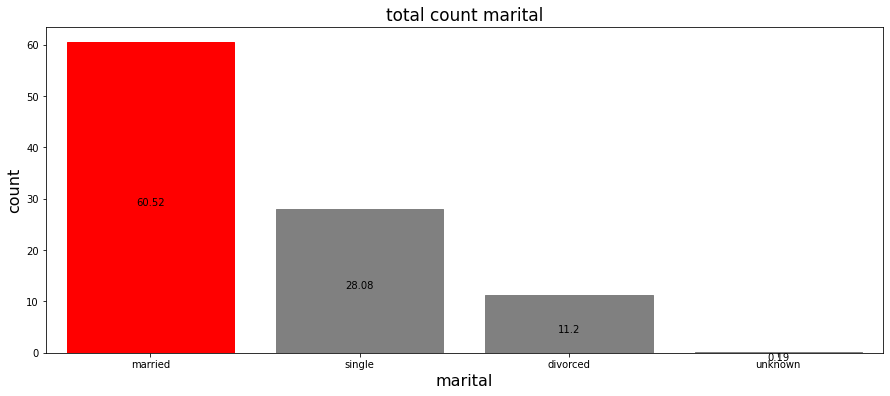

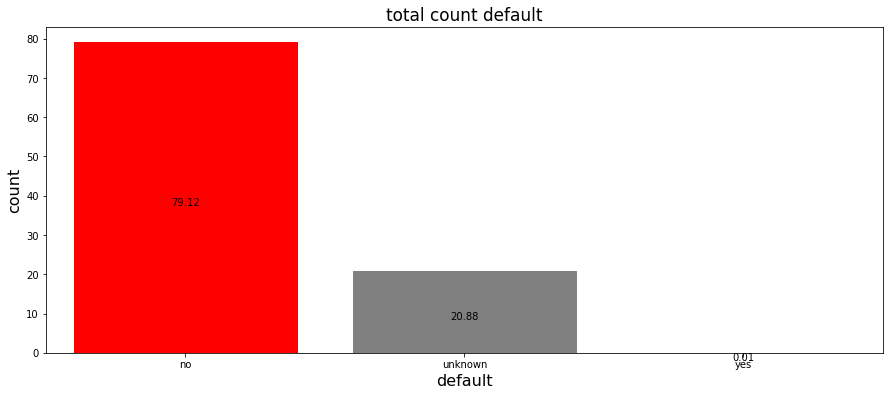

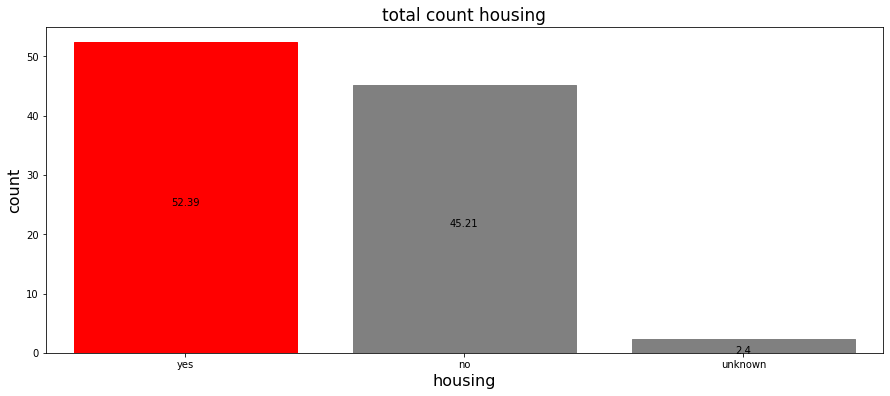

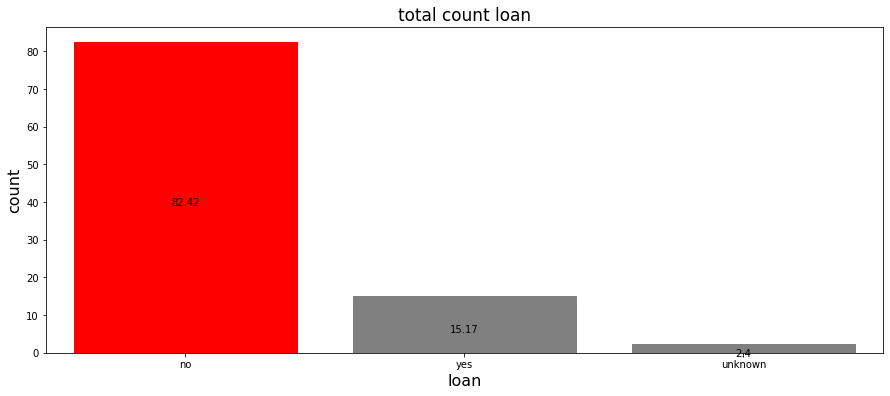

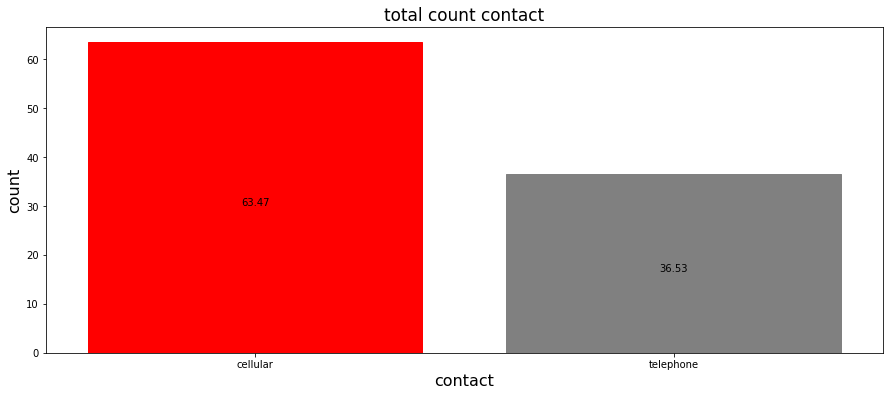

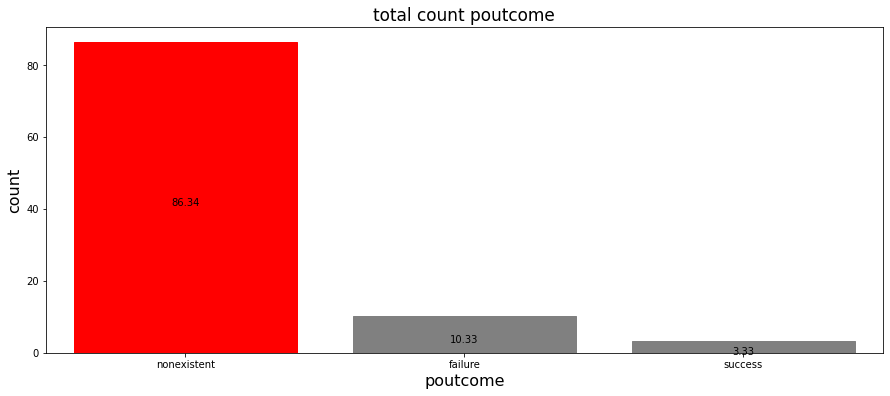

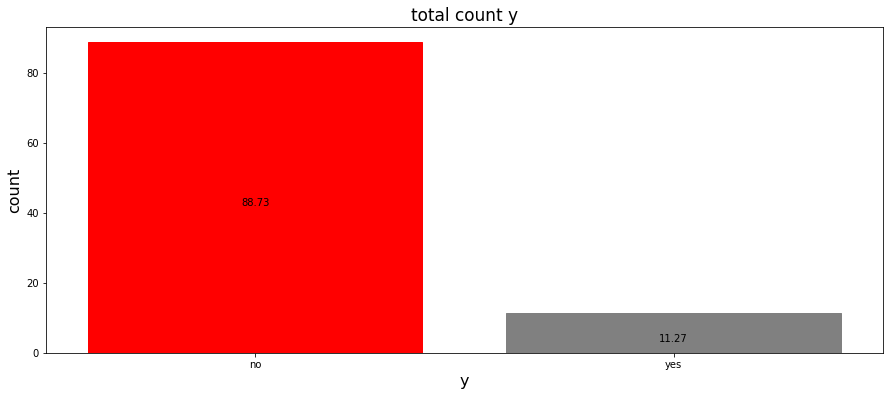

In [47]:
for col in columns_50:
  plot_bar(bank_marketing, col)

beberapa informasi yang didapatkan :
1. mayoritas data client berasal dari client atau customer yang menikah diikuti, jomblo dan cerai. dengan sekitar 60 % berasal dari orang menikah, ada kemungkinan client yang menikah akan berpengaruh terhadap berhasil atau tidaknya subscribe term deposit

2. mayoritas client kita (untuk campaign) tidak memiliki credit, di column juga terlihat bahwa , 20 % dari datanya merupakan missing value ('unknown'). dengan banykanya data unknown, dapat mempengaruhi prediksi kita sehingga ada kemungkinan bahwa column lebih baik dihapus

3. housing column memiliki presentase yang lebih proporsional daripada 2 column sebelumnya dimana 52 persen client memiliki housing loan sedangkan 45 % tidak memiliki housing loan, terlepas dari missing value (0.08 %) kita melihat bahwa column housing sendiri bukan imbalance features karena selisih antara value 'no' and 'yes'  sedikit (sekitar 7 %) sehingga ada kemungkinan kedua value berpengaruh terhadap kemampuan machine learning dalam memprediksi kondisi. Sedangkan untuk missing value, strategi yang akan dilakukan adalah merubah data missing value ke value 'yes' (selain karena strategi paling mudah, dengan selisih 7 % penambahan data 'yes' tidak akan mempengaruhi secara drastis ketika data dimasukkan ke dalam algoritma)

4. column loan menunjukkan kondisi inbalance features karena 80 % berasal dari value 'no', atau 80 % client kita tidak memiliki personal loan, sedangkan 15 persen memiliki personal loan dan sisanya merupakan missing value, selisih yang begitu besar ini dapat mempengaruhi kemampuan algoritma machine learning, karena machine learning akan lebih mengenali data dengan jumlah value lebih besar daripada yang lebih kecil. Terlepas apakah kita nanti menghapus column tersebut atau tidak, lebih baik diidentifikasi lebih dalam, terutama pengaruhnya dengan columns yang lain. Sedangkan pada value 'unknown', strategi yang akan dilakukan sama seperti column housing, yaitu merubah value nya ke value yang memiliki jumlah paling tinggi ('no'), hal ini dilakukan karena penambahan 2,4 persen pada value 'no' tidak akan mempengaruhi secara drastis terhadap algoritma klasifikasi.

5. column contact menunjukkan bahwa client kita lebih banyak berkontak menggunakan cellular (hp) daripada telephone. walaupun column juga mennunjukkan pattern inbalanced (63 % vs 36 %) investastigasi lebih lanjut.

6. terlepas dari target column (y) kita bisa menyimpulkan bahwa column poutcome memiliki kondisi inbalance paling buruk diantara categorical column yang lain. dengan mayoritas client memiliki value 'no' atau mayoritas client (86 %) berasal dari kegagalan campaign sebelumnya, akan berpangaruh dengan data target kita, sehingga peluang dihapus akan sangat besar.

7. y adalah data atau column yang akan kita lakukan prediksi atau klasifikasi, dengan kondisi inbalance, kita perlu melakukan langkah strategis agar algorithma machine learning yang nanti kita gunakan tidak salah mengkalsifikasi data misal melakukan oversampling, undesampling dan weightbalance serta memilih algorithma yang lebih robust terhadapat kondisi inbalance

## Multivariate Analysis

### Label Converter

In [48]:
#change target columns
#yes = 1.0
#no = 0.0
indexer = StringIndexer(inputCol = 'y', outputCol = 'yIndex')
model = indexer.fit(bank_marketing)
bank_marketing2 = model.transform(bank_marketing)

bank_marketing2 = bank_marketing2.drop('y')

bank_marketing2.show()

+---+------------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+------+
|age|         job| marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|yIndex|
+---+------------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+------+
| 42|      admin.| married|  university.degree|     no|     no| yes|telephone|  may|        mon|     262|       2|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0|   0.0|
| 49| blue-collar| married|        high.school|unknown|     no|  no|telephone|  may|        tue|      69|       1|  999|       0|nonexistent|       

### Correlations between numeric columns

In [49]:
continuous_columns =[col[0] for col in bank_marketing.dtypes if col[1] != 'string']

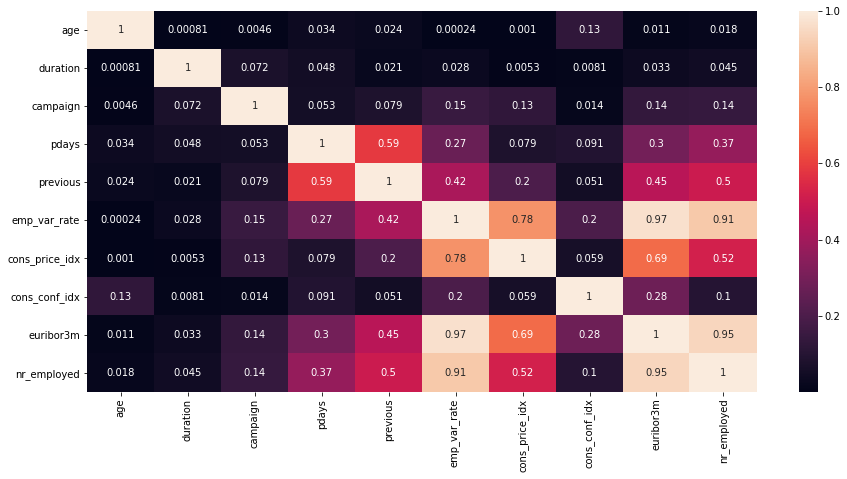

In [50]:
from pyspark.mllib.stat import Statistics
numeric_data = bank_marketing.select(continuous_columns)

features = numeric_data.rdd.map(lambda row: row[0:])
corr_df =Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_df).abs()
corr_df.index, corr_df.columns = continuous_columns, continuous_columns

plt.figure(figsize=(15,7))
ax = sns.heatmap(corr_df, annot=True, fmt='.2g')
plt.show()

ada beberapa hal yang menarik mengenai visualisasi diatas
1. emp_var_rate menunjukkan korelasi yang tinggi euribor3m sekitar 97 %
2. nr_employed mempunyai korelasi 95 % dengan euribor3m
3. nr_employed memiliki korelasi 91 % emp_var_rate


kasus ini biasa dinamakan multicololinearity, yaitu kondisi features yang memiliki korelasi yang tinggi dengan features yang lain sehingga  memiliki peluang dapat menurunkan akurasi algortihma machine learning untuk menklasifikasi suatu kasus,

dalam beberapa kasus, rencana yang paling baik adalah dengan memilih salah satu dari column atau features yang memiliki korelasi yang tinggi. Namun apakah ini solusi yang tepat harus dilakukan identifikasi yang lebih lanjut, karena bisa jadi walaupun 2 columns tersebut memiliki korelasi tinggi juga dapat memiliki informasi yang berbeda

#### Correlations between numeric columns and label

In [51]:
continuous_columns =[col[0] for col in bank_marketing.dtypes if col[1] != 'string']

#change label data to int
df_continuous = bank_marketing.select(continuous_columns + ['y'])
df_continuous = df_continuous.withColumn('y',
                                         when(F.col('y') == 'no',0).otherwise(1))


In [52]:
def point_biserial_corr(datas, target, columns=[], sort_value = False):
  if columns==[]:
    return 'error'
  
  new_col = columns + [target]
  df_col = datas.select(new_col)

  y_target = np.array(datas.select(target).collect()).flatten()

  dict_biserial = {}
  for col in columns:
    x_features = np.array(datas.select(col).collect()).flatten()
    point_biserial_val = stats.pointbiserialr(y_target, x_features)

    dicts_col ={}
    dicts_col['corr_value'] = point_biserial_val[0]
    dicts_col['p_value'] = point_biserial_val[1]

    dict_biserial[col] = dicts_col

  df_biserial = pd.DataFrame.from_dict(dict_biserial).T

  if sort_value == False:
    return df_biserial
  elif sort_value == True:
    return df_biserial.reindex(df_biserial.corr_value.abs().sort_values(ascending=False).index)



In [53]:
df_corr = point_biserial_corr(df_continuous, 'y', continuous_columns, sort_value=True)
df_corr

,corr_value,p_value
duration,0.405297,0.000000e+00
nr_employed,-0.354669,0.000000e+00
pdays,-0.324948,0.000000e+00
euribor3m,-0.307740,0.000000e+00
emp_var_rate,-0.298289,0.000000e+00
previous,0.230202,0.000000e+00
cons_price_idx,-0.136134,1.622233e-169
campaign,-0.066361,2.043431e-41
cons_conf_idx,0.054802,9.132176e-29
age,0.030381,7.003244e-10


menggunakan point biserial correlation, kita mengetahui bahwa duration memiliki korelasi paling tinggi, diikuti nr_employed and pdays, nilai negative dan positive berhubungan dengan kondisi korelasinya.

pada duration, semakin tinggi durasinya, client cenderung mengsubscribe campaign sedangkan rendah durasinya, cenderung tidak mensubscribe campaign.

sedangkan pada nr_employed and pdays, client tidak mensubscribe jika nilanya tinggi

selain itu, kita juga mengetahui bahwa semua data mempunyai korelasi dibawah 0.5

#### Numeric columns vs label visualization

In [54]:
def plot_violinplot(datas, columns):
  dist_data = datas.select(columns, 'y').toPandas()

  dist_data['y'] = dist_data['y'].replace({'no':0, 'yes':1})

  plt.figure(figsize=(15,7))
  ax = sns.catplot(x='y', y=columns, kind="violin", data=dist_data)
  plt.title(dist_data.columns[0])

  plt.show()

  return ax


<Figure size 1080x504 with 0 Axes>

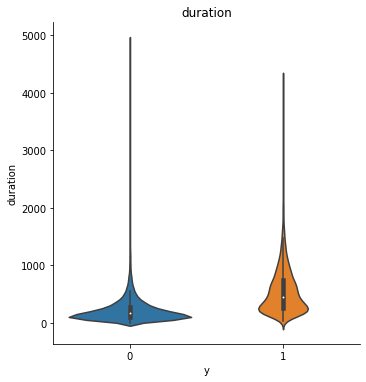

<Figure size 1080x504 with 0 Axes>

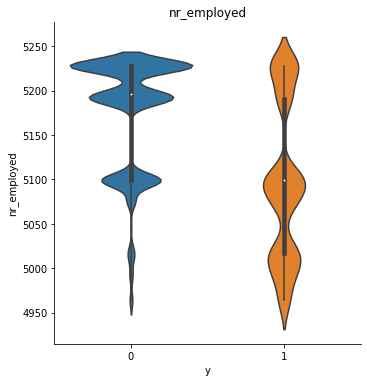

<Figure size 1080x504 with 0 Axes>

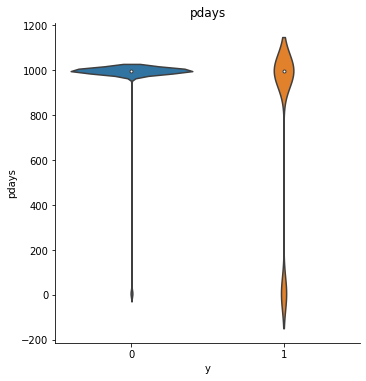

<Figure size 1080x504 with 0 Axes>

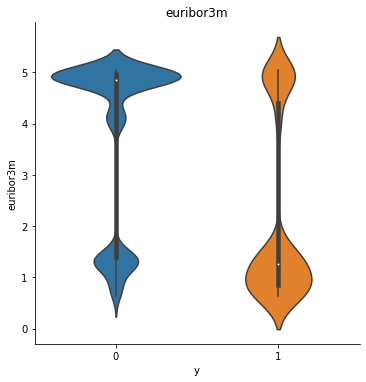

<Figure size 1080x504 with 0 Axes>

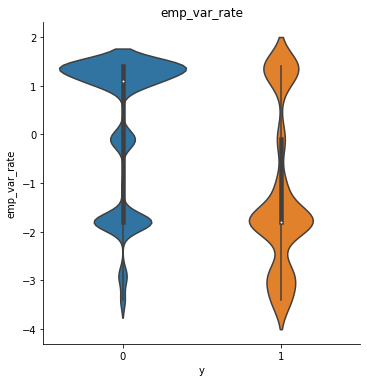

<Figure size 1080x504 with 0 Axes>

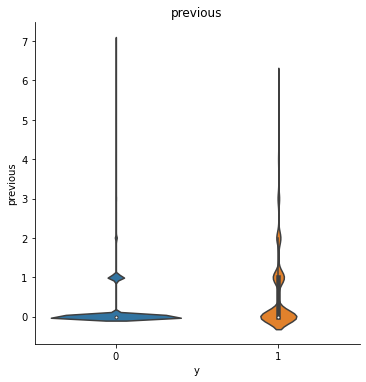

<Figure size 1080x504 with 0 Axes>

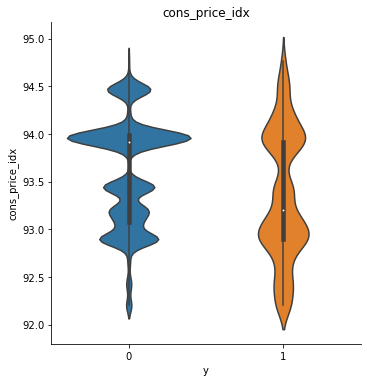

<Figure size 1080x504 with 0 Axes>

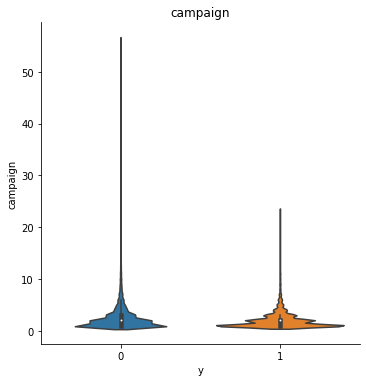

<Figure size 1080x504 with 0 Axes>

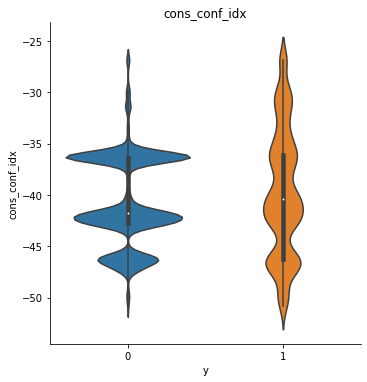

<Figure size 1080x504 with 0 Axes>

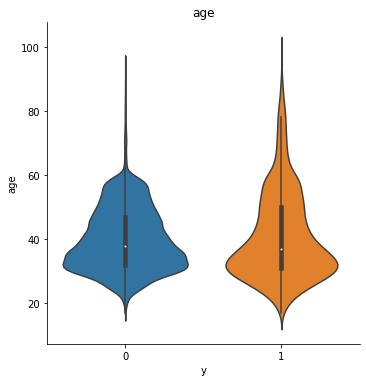

In [55]:
df_columns = [x for x in df_corr.index]
for col in df_columns:
  plot_violinplot(bank_marketing, col)

dengan mengganti 0 == 'no' dan 1 == yes, Beberapa hal yang didapat:
1. column duration memiliki perbedaan yang cukup mencolok antara data == 'yes' dan data == 'no', data == 'no'memiliki kepadatan peluang yang lebih tinggi daripada data == 'yes' yang menunjukkan menunjukkan bahwa client dengan durasi telpon yang lebih kecil cenderung tidak menscubscribe term deposite dari bank

2. pada columns nr_employeed, visualisasi terlihat lebih abstrack daripada column duration. Namun kita juga dapa melihat ada beberapa perbedaan. Di posisi median data == 'no' (titik 5200 atau lihat titik berwarna putih) memiliki kepdatan peluang lebih besar (lebih cembung) dari pada data == 'yes', yang memperlihatkan bahwa client yang memiliki nr_employeed yang tinggi cenderung tidak mensubscribe term deposite. Sedangkan pada posisi median data=='yes' (titik 5100 serta kebawahnya) memiliki kepadatan peluang lebih besar daripada data=='no' atau memperlihatkan bahwa client yang memiliki nr_employee yang rendah cenderung mensubscribe term deposite dari bank (kebalikan dari column duration)

3. columns pdays memiliki pattern yang sama dengan column nr_employee dimana jika kita perhatikan bagian median(titik putih) dikedua data 'no' dan 'yes', data 'no' memiliki kepadatan peluang lebih besar daripada data 'yes' diposisi diatas 1000 yang menunjukkan client yang memiliki nilai pdays(jarak terhadap kontak terakhir) yang tinggi cenderung tidak mensubscribe  term deposite

4. column euribor3m dan emp_var_rate juga memiliki kesamaan pattern dengan kedua columns diatas, dengan melihat salah satu titik median misal median data 'no' dititik diatas 4 (untuk eutribor3m) dan titik diatas 0 (untuk emp_var_rate), kita bisa melihat bahwa data 'no' memiliki kepadatan peluang lebih besar daripada data 'yes' sehingga client dengan  euribor3m yang lebih tinggi cenderung tidak mensubscribe term deposite

5. column previous memiliki pattern yang sama dengan column duration, jika kita perhatikan pada titik nilai previous < 1, terlihat bahwa data='no' memiliki kepadatan peluang lebih tinggi daripada data='yes' yang menandakan client yang tidak dilakukan contact sebelumn campaign (previous == 0) cenderung tidak mensubscribe term deposite

6. column cons_price_idx memiliki bentuk violin plot yang lebih abstrack namun jika kita perhatikan di salah satu titik median (menggunakan median data 'no') 94 keatas, terlihat bahwa data 'no' cenderung memiliki visualisasi kepadatan peluang lebih besar daripada data 'yes', sehingga disimpulkan pada client dengan cons_price_idx yang tinggi cenderung tidak mensubscribe term deposite

7. Hal unik terjadi dengan column campaign, pada column campaign (lihat titik putih dan nilai dibawah 5) data 'yes' mempunyai kepadatan peluang lebih besar daripada column 'no', sehingga dapat disimpulkan bahwa contact yang dilakukan kepada client berpengaruh terhadap client yang mau mensubscribe term deposite dimana sedikitnya contact cenderung membuat client mau mensubscribe term deposite

8. column cons_conf_idx dan column age, memiliki visualisasi yang hampir hirip, hal itu juga juga bisa terlihat pada nilai point biserial corelation yang sangat rendah (sekitar 0,0), namun jika kita lihat p_value, kedua column tersebut masih memiliki korelasi, sehingga  beberapa strategi bisa dilakukan sebelum memutuskan apa perlu menghapus atau tidak kedua column tersebut

### Correlations between Categorical Columns

In [56]:
str_columns =[col[0] for col in bank_marketing.dtypes if col[1] == 'string']

str_columns



['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

In [57]:
# def chi_square_test(data, col_label):
#   cat_columns = [col[0] for col in data.dtypes if col[1] == 'string']
#   cat_df = bank_marketing.select(cat_columns)

#   #indexing label
#   str_indexer = StringIndexer(inputCol = col_label, outputCol = 'label')
#   model_label = str_indexer.fit(cat_df)
#   cat_df = model_label.transform(cat_df)

#   cat_df = cat_df.drop(col_label)

#   #indexing features
#   str_cat_dfcol = [col[0] for col in cat_df.dtypes if col[1] == 'string']

#   ##create_indexers
#   string_indexers = [StringIndexer(inputCol=col, outputCol = '{}_indexed'.format(col)) for col in str_cat_dfcol]

#   ##vector assembler
#   assembler = VectorAssembler(inputCols=[string_indexer.getOutputCol() for string_indexer in string_indexers],
#                             outputCol = 'features')

#   pipeline_chisquare = Pipeline(stages=string_indexers + [assembler])

#   ##fit and transform pipeline into the data
#   model_chisquare = pipeline_chisquare.fit(cat_df)
#   new_cat_df = model_chisquare.transform(cat_df)

#   new_cat_df = new_cat_df.select('features','label')

#   #ChisquareTest
#   r = ChiSquareTest.test(new_cat_df, "features", "label")
#   sdf = np.array(r.select('pValues').collect())
#   sdf = sdf[0][0].tolist()

#   loc_label = cat_columns.index(col_label)
#   sdf.insert(loc_label, 0.0)
  

#   return sdf



# txt_columns = ['job','marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome','y']
# list_chisquare = {}

# for i in txt_columns:
#   chis_q = chi_square_test(bank_marketing, i)
#   list_chisquare[i] = chis_q

# df_chisquare_corr = pd.DataFrame.from_dict(list_chisquare)
# df_chisquare_corr.index = txt_columns

# plt.figure(figsize=(15,7))
# ax = sns.heatmap(df_chisquare_corr, annot=True, fmt='.2g')
# plt.show()
  

In [58]:
from collections import Counter
import math
from scipy.stats import entropy

def conditional_entropy(datas, col_target, col_features):
  # entropy of col_target given col_features
  # entropy of x given y
  df_cond = datas.select(col_features, col_target).toPandas()

  c_features = Counter(df_cond[col_features])
  c_target_features = Counter(list(zip(df_cond[col_target], df_cond[col_features])))
  total_data = sum(c_features.values())
  entropy = 0
  for xy in c_target_features.keys():
    p_xy = c_target_features[xy] / total_data
    p_y = c_features[xy[1]] / total_data
    entropy += p_xy * math.log(p_y / p_xy)

  return entropy



def theils_u_corr(datas, col_target, col_features):

  s_target_features = conditional_entropy(datas, col_target, col_features)
  df_entropy = datas.select(col_target, col_features).toPandas()

  c_target = Counter(df_entropy[col_target])
  total_data = sum(c_target.values())

  p_target = list(map(lambda x: x / total_data, c_target.values()))
  s_target = entropy(p_target)

  if s_target == 0:
    return 1
  else:
    return (s_target - s_target_features) / s_target

theils_u_corr(bank_marketing, 'y','loan')


def theils_u_table(dataframes):
  cat_columns = [col[0] for col in dataframes.dtypes if col[1] == 'string']

  cat_df = dataframes.select(cat_columns)


  all_theils = {}
  for i in cat_columns:
    dict_theils = {}

    for col in cat_columns:
      theils_u_value = theils_u_corr(cat_df, i, col)
      dict_theils[col] = theils_u_value

    all_theils[i] = dict_theils

  return pd.DataFrame.from_dict(all_theils)








In [59]:
from scipy.stats import chi2_contingency

def cramer_v(datas, col_features, col_target):
  new_df = datas.select(col_features, col_target).toPandas()
  conf_matrix = pd.crosstab(new_df[col_features], new_df[col_target])
  chi_square = chi2_contingency(conf_matrix)[0]
  n = conf_matrix.sum().sum()

  phi2 = chi_square / n
  r, k = conf_matrix.shape

  phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
  rcorr = r - ((r-1)**2)/(n-1)
  kcorr = k - ((k-1)**2)/(n-1)

  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def cramer_v_table(dataframes):
  cat_columns = [col[0] for col in dataframes.dtypes if col[1] == 'string']

  cat_df = dataframes.select(cat_columns)


  all_cramer = {}
  for i in cat_columns:
    dict_cramer = {}

    for col in cat_columns:
      if col == i:
        dict_cramer[col] = 1.0
      else:
        cramer_v_value = cramer_v(cat_df, col, i)
        dict_cramer[col] = cramer_v_value

    all_cramer[i] = dict_cramer

  return pd.DataFrame.from_dict(all_cramer)

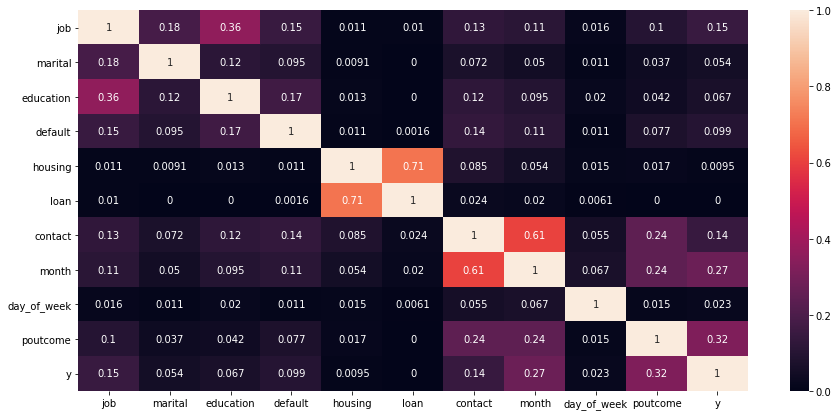

In [60]:
sdf = cramer_v_table(bank_marketing)

plt.figure(figsize=(15,7))
ax = sns.heatmap(sdf, annot=True, fmt='.2g')
plt.show()

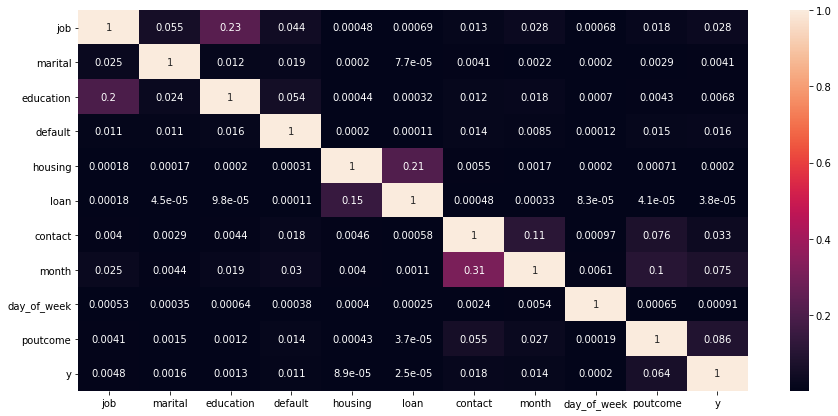

In [61]:
sdf = theils_u_table(bank_marketing)

plt.figure(figsize=(15,7))
ax = sns.heatmap(sdf, annot=True, fmt='.2g')
plt.show()

menggunakan theils u sebagai base pertama dalam melihat hubungan antar data categorical didapatkan kondisi dimana data memiliki value yang sangat rendah (mendekati 0). Untuk menyelediki kenapa hal ini bisa terjadi, kita bisa melakukan visualisasi lebih mendalam per columnya.

Namun, karena kita akan lebih fokus untuk melihat korelasi antar features dengan column target, kita bisa memulainya dengan menvisualisasi hal tersebut

#### nominal columns vs Label

In [62]:
# def plot_pointplot(datas, columns):
#   dist_data = datas.select(columns, 'y').toPandas()

#   dist_data['y'] = dist_data['y'].replace({'no':0, 'yes':1})

#   plt.figure(figsize=(15,7))
#   ax = sns.barplot(x=columns, y='y', data=dist_data)
#   plt.title(dist_data.columns[0])

#   return ax

In [63]:
def cat_plot(datas, columns, hue):
  new_df = datas.select(columns, hue).toPandas()
  

  fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,16))
  ax1, ax2 = ax.flatten()
 

  #crosstab
  df_crosstab = pd.crosstab(new_df[columns], new_df[hue])
  unique_df = df_crosstab.index.tolist()
  title = 'Stacked Barplot {}'.format(columns)
  df_crosstab.plot.bar(ax=ax1, title=title,stacked=True, rot=45)
  for p in ax1.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax1.text(x+width/2, 
            y+height/2, 
            height, 
            horizontalalignment='center', 
            verticalalignment='center')
  
  #barplot
  dict_replace = {}
  for idx, x in enumerate(new_df[hue].unique()):
    dict_replace[x] = idx
  new_df[hue] = new_df[hue].replace(dict_replace)
  title2 = 'Barplot (mean central tendency) {}'.format(columns)
  sns.barplot(ax=ax2, x=columns, y=hue, data=new_df, order=unique_df)
  ax2.set_title(title2)

  fig.suptitle(columns, y = 0.92, fontsize=16)
  plt.show()

  return ax


In [64]:
# def stacked_barplot(datas, columns, hue):
#   idx = '{}_{}'.format(columns, hue)
#   df_crosstab = datas.stat.crosstab(columns, hue).toPandas().set_index(idx)
#   df_crosstab.columns = ['no','yes']

#   plt.rcParams["figure.figsize"] = 15,8
#   ax =  df_crosstab.plot.bar(title= columns,stacked=True)
#   ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

#   for p in ax.patches:
#     width, height = p.get_width(), p.get_height()
#     x, y = p.get_xy() 
#     ax.text(x+width/2, 
#             y+height/2, 
#             height, 
#             horizontalalignment='center', 
#             verticalalignment='center') 

#   plt.legend(title='label')

#   plt.show()

#   return ax

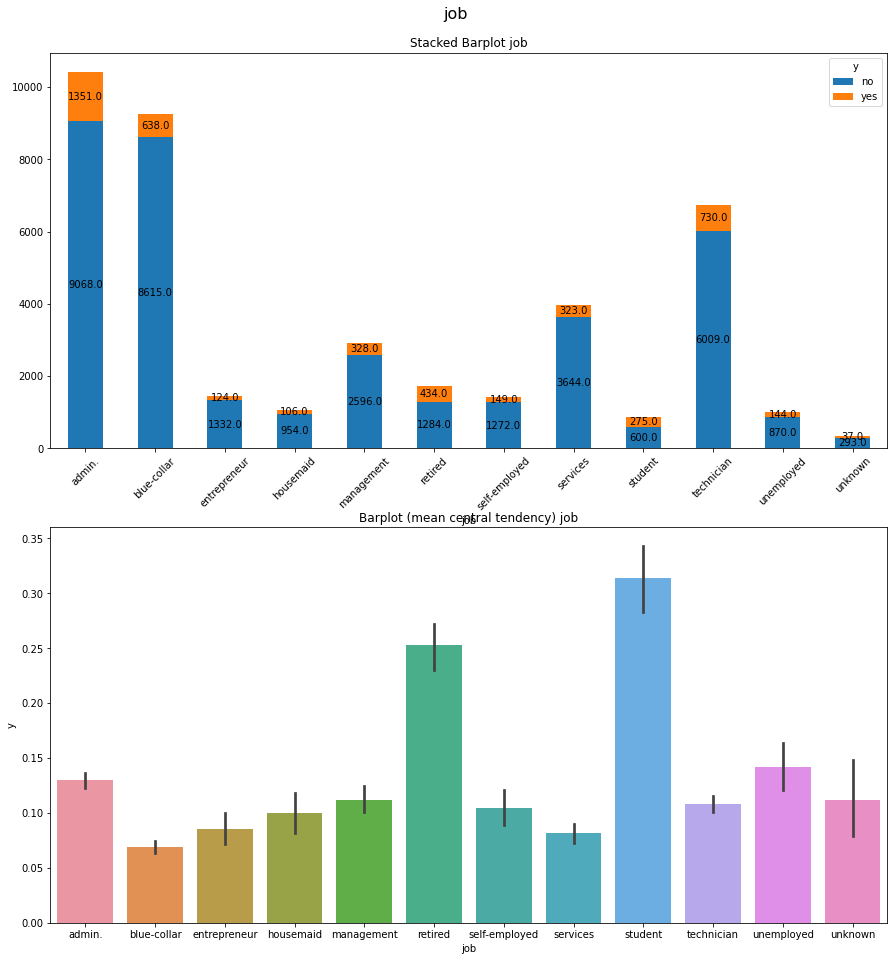

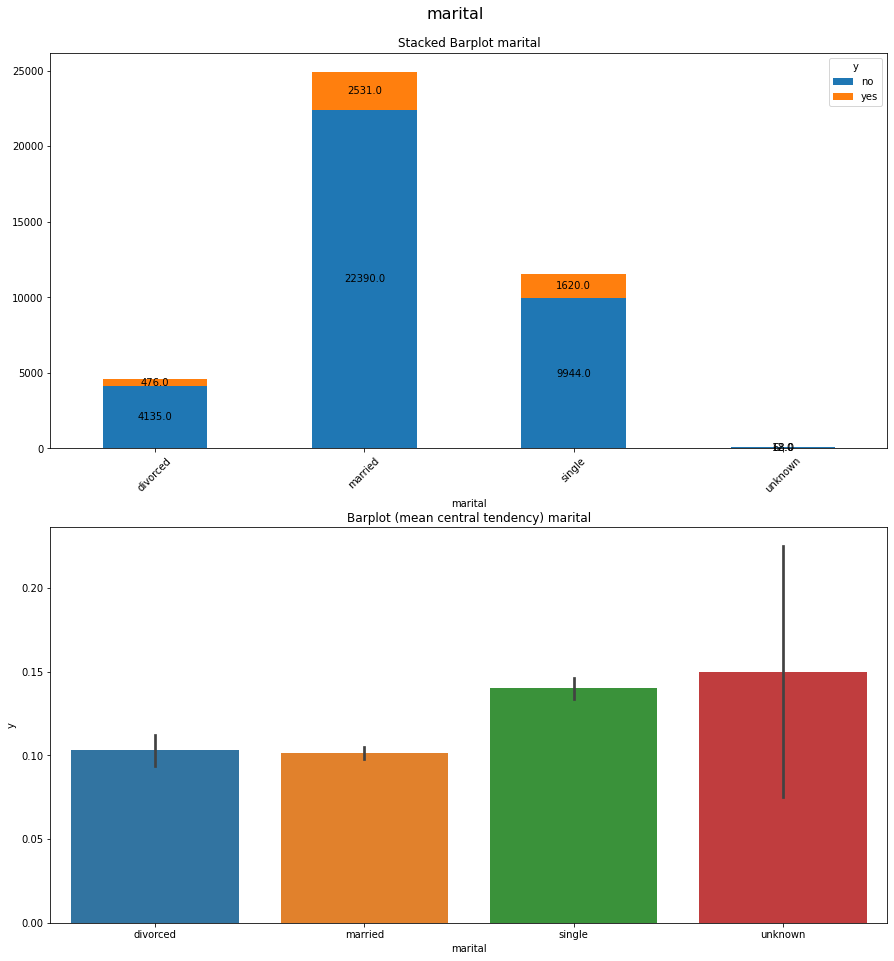

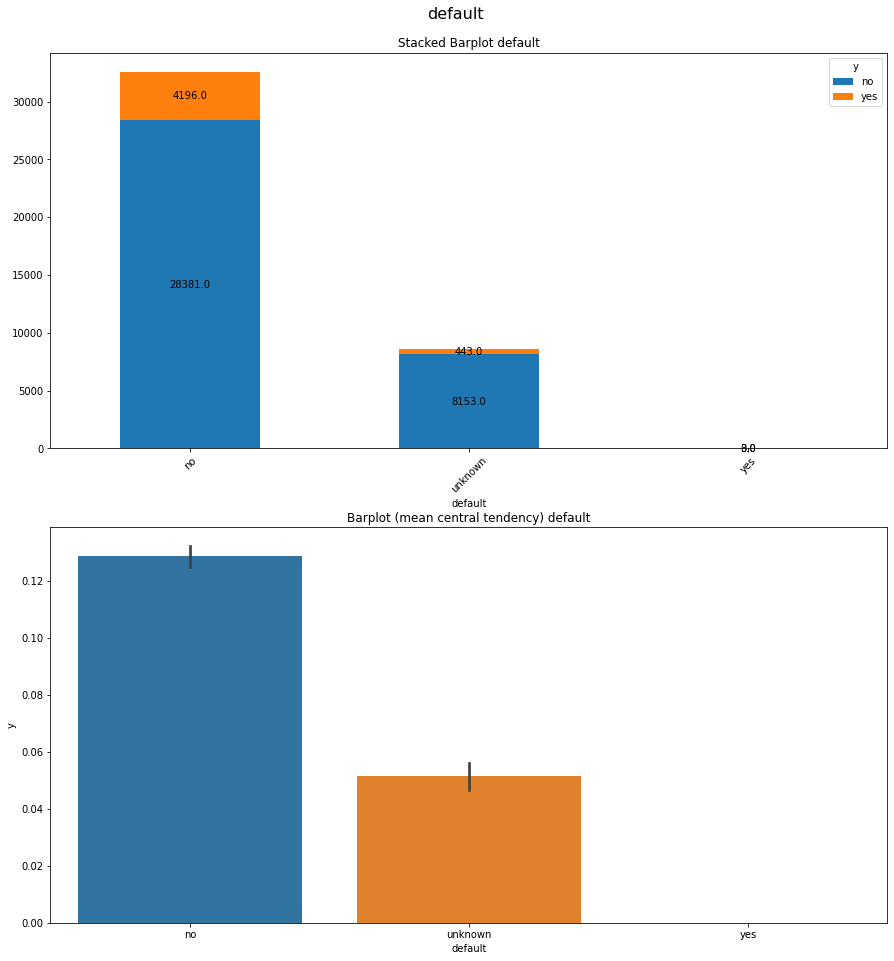

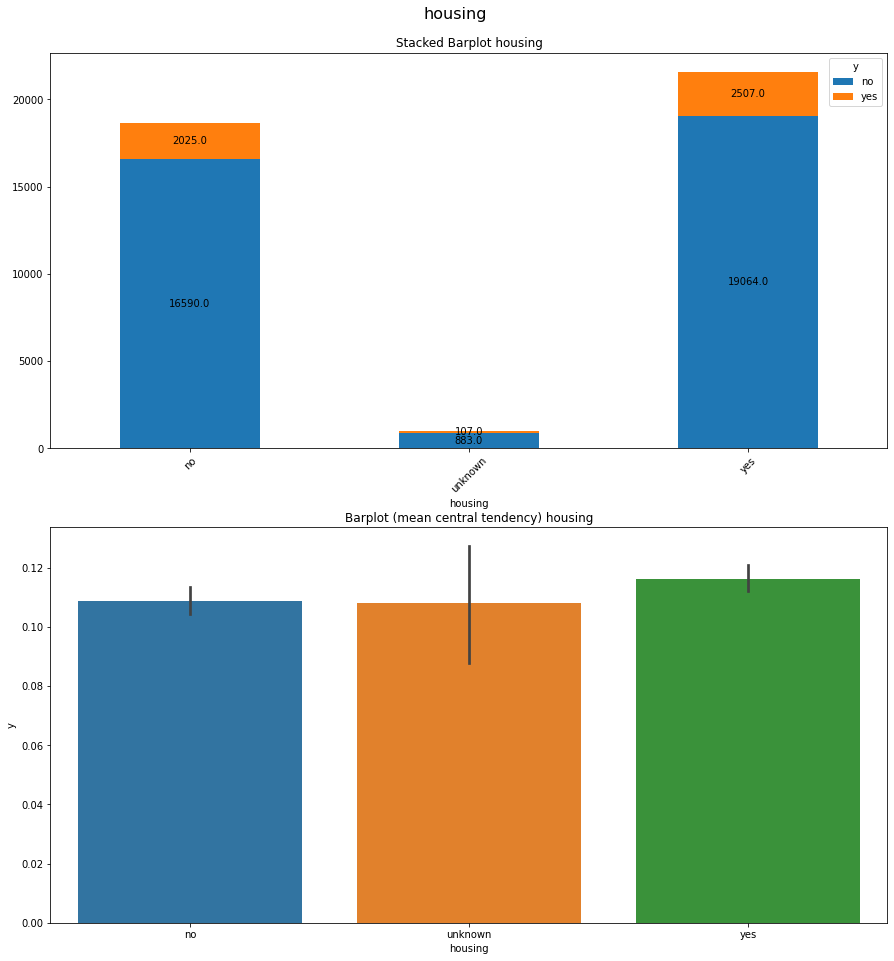

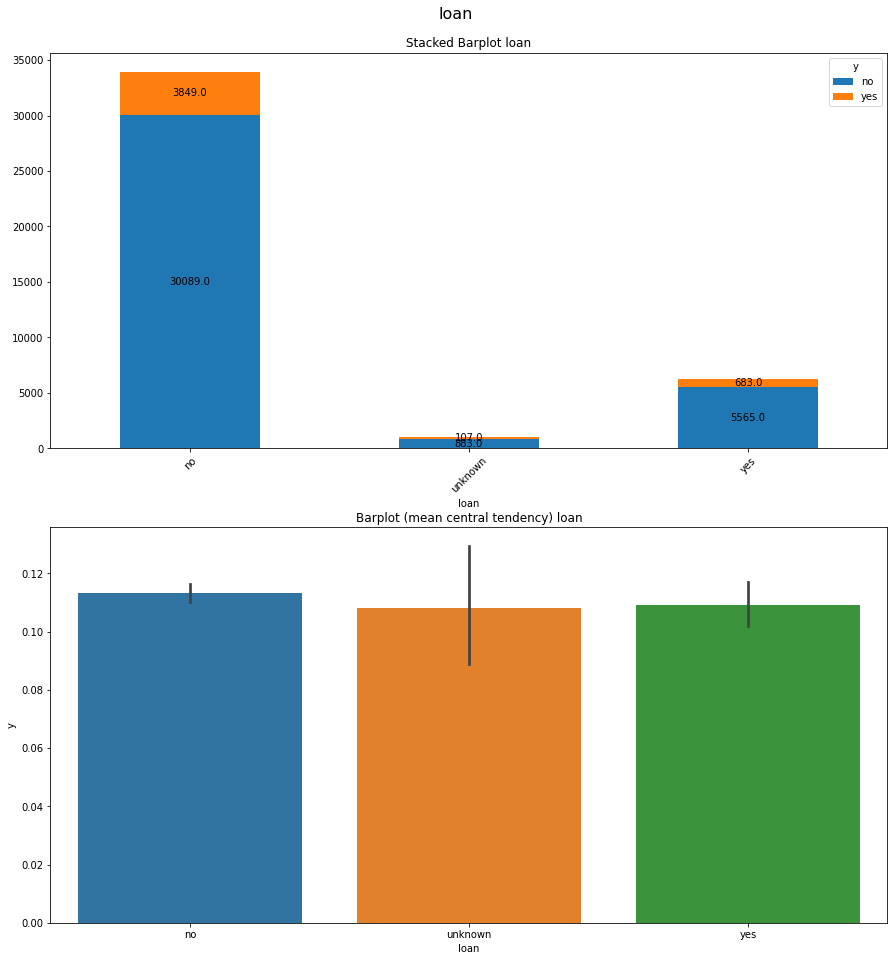

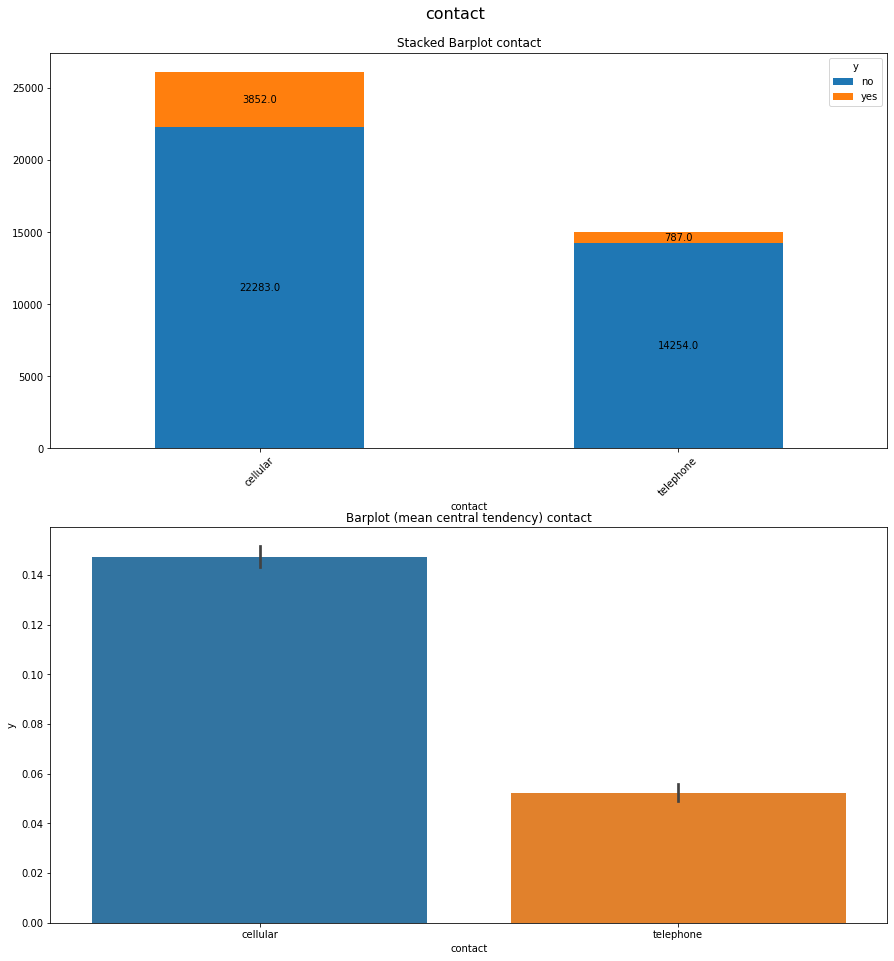

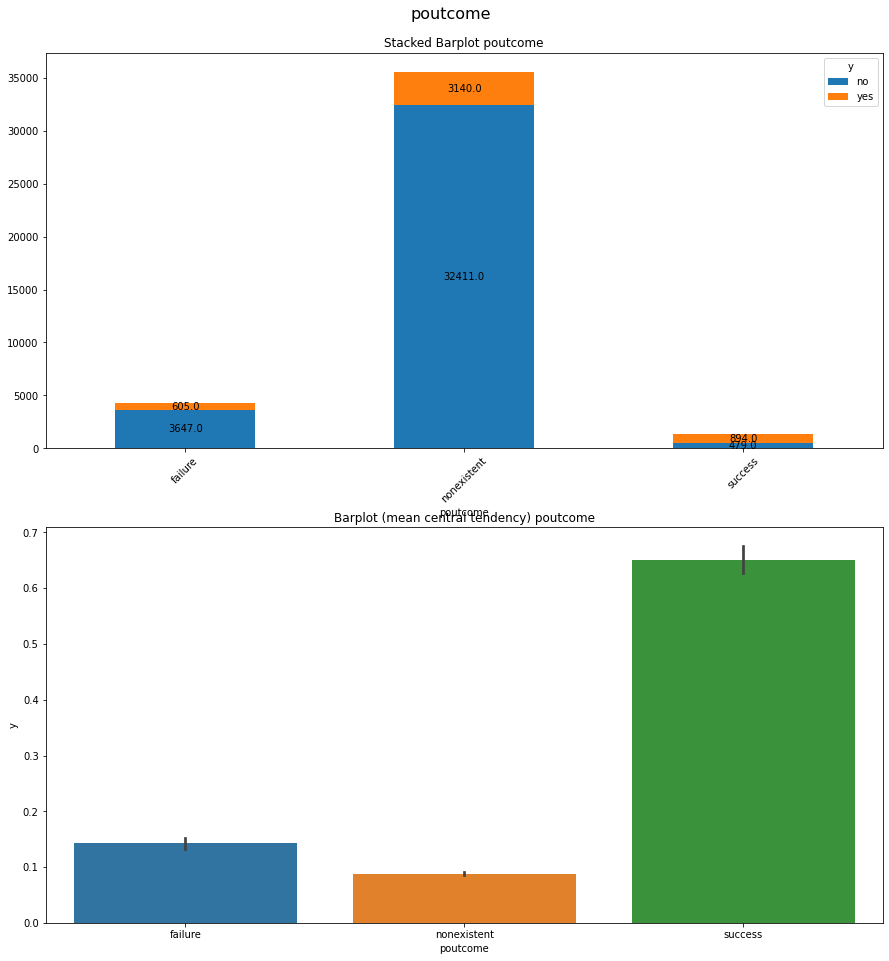

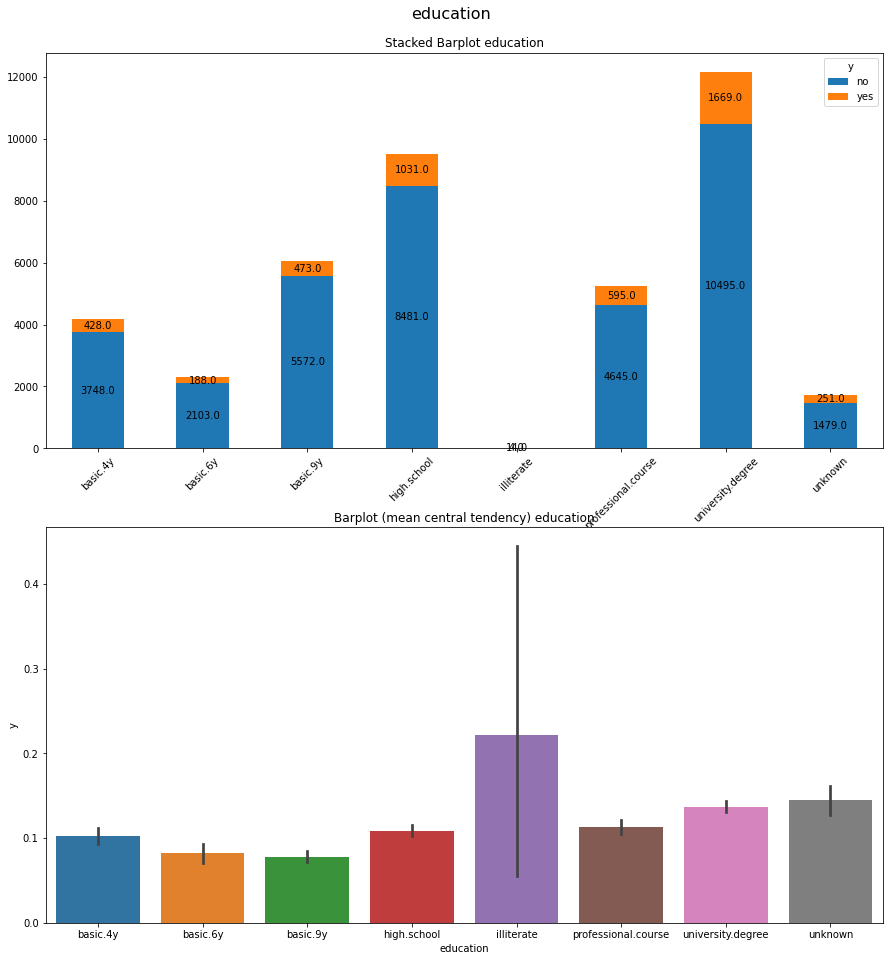

In [65]:
nominal_columns = ['job', 'marital', 'default', 'housing', 'loan','contact','poutcome','education']
for col in nominal_columns:
 cat_plot(bank_marketing, col,'y')

Menggunakan central tendency (mean yang diatributkan oleh point) terlihat beberapa informasi:
1.  pada column job, walaupun student dan retired memiliki error bar yang sedikit tinggi (diperlihatkan oleh panjang pendeknya garis vertikal), kedua value tersebut cenderung memiliki mean yang paling tinggi, yang berarti ada porsi y=1 atau subscribe term deposite yang lumayan besar di kedua value tersebut, hal ini menunjukkan adanya peluang client yang berasal dari kalangan pelajar (job = 'student') dan client dari kalangan pensiunan (job = 'retired') censerung akan mensubcribe term deposite dimasa yang akan datang.

2. Pada column marital, diperlihatkan bahwa client dengan status single(belum menikah) memiliki mean paling tinggi daripada value yang lain. dimana juga menunjukkan ada peluang jika client dengan status  single akan cenderung mensubribe term deposite, namun karena range nya yang berada dibawah 0.20 (akibat inbalanced) kita tidak bisa secara eksplisit harus memprioritaskan client dengan status single, perlu adanya confident lebih lanjut dengan menggabungkan column lain, misal dengan job atau education (misal client dengan status belum menikah dan student) untuk melihat apakah meannya akan lebih tinggi atau tidak, namun untuk awal kita bisa menyatakan untuk sementara jika client single memiliki peluang yang lebih besar. Juga kita diperlihatkan client 'unknown' yang memiliki error yang sangat tinggi (lihat panjang garis vertikal) yang mengindikasikan persebaran data mean yang lebih merata (karena interval garis, ujung ke ujung interval panjang),sehingga untuk selanjutnya kita bisa mengganti value unknown dengan modus pada column tersebut. Terakhir, column marital juga menunjukkan adanya persamaan antara value 'married' dan 'divorce' dimana kedua value memiliki mean yang hampir sama (lihat ketinggian bar), serta garis vertikal menunjukkan saling timpang tindih (ada kemungkinan tidak ada 'statistically significant') antara 'married' dan 'divorce' (bisa disimpulkan client yang sudah menikah dan client yang cerai tidak terlalu berpengaruh terhadap client akan mensubscribe term deposite atau tidak) sehingga kita bisa membuat alternative (misal menggabungkan 'married' dan 'divorce' menjadi 'no single')

3. column default menunjukkan beberapa informasi menarik, dimana client dengan kondisi default 'no' atau sebelumnya tidak mempunyai credit mempunyai mean yang paling tinggi (ada kemungkinan orang yang tidak mempunyai kredit cenderung akan mengambil atau mensubscribe term deposite). Selanjutnya, terlihat bahwa value 'unknown' berada diperingkat kedua dengan value mean tertinggi dan client dengan kondisi mempunyai kredit (default == 'yes') memiliki value yang sangat rendah (sekitaran nol) yang mana bisa mengindikasikan beberapa hal, pertama, client yang kondisi default nya tidak diketahui memiliki jumlah yang sangat besar (terlihat dari distribusinya) dan mempunyai central tendency yang kecil (akibar imbalance di data 'y') yang mana menunjukkan ada informasi penting pada value unknown, sehingga strategi paling baik adalah tidak merubah value tersebut. kedua, column default memiliki range sangat kecil, dibawah 0.15, yang mana perlu menggabungkan column default dengan column yg lain untuk memperkuat confidence apakah default mempengaruhi keputusan client yang akan melakukan subscribe term deposite. ketiga, secara eksplisit, antara value 'no' dan 'unknown' memiliki selisih mean yang lumayan tinggi sehingga kemungkinan column ini mempengaruhi column 'y'. keempat, value 'yes' memiliki jumlah yang sangat kecil, alternativenya adalah merubahnya ke column lain atau menghapus row yang memiliki value default 'yes', namun itu tergantung jumlah row yang memiliki kondisi default 'yes'

4. column housing memiliki central tendency (mean) yang hampir sama antara client yang memiliki pinjaman housing (housing='yes') dengan client yang tidak memiliki pinjaman housing ('housing' == 'no') hal ini cukup menyulitkan untuk mencari yang mana yang lebih cenderung akan mensubscribe term deposite (dikarenakan perbadaan yang cukup rendah) dimana hal ini bisa terjadi karena jumlah client yg hampir sama antara 'no' dan 'yes', serta tidak adanya perbedaan jumlah yang significant antara jumlah client housing yg mensubscribe y == 'yes' dan tidak mensubscribe y == 'no' (perlu lihat distribusinya), sedangkan untuk 'unknown' kita bisa melihat adanya persamaan pattern dengan column marital dimana 'unknown' memiliki error bar yg cukup tinggi, untuk sementara strategi paling sederhana adalah merubah value 'unknown' ke modus column housing ataupun merubahnya berdasarkan kondisi di column lain (misal pakai machine learning), tapi itu semua tergantung apakah akan berpengaruh pada algorithma atau tidak, ataupun jumlah client 'unknown' pada column housing sendiri.

5. hal yang lebih menarik terlihat pada column loan, dimana antara client yang punya pinjaman (loan == 'yes'), client yg tidak punya pinjaman ('no'), serta null values ('unknown') memiliki  central tendecy mean yang cenderung memiliki tingkat perbedaan yang rendah, serta jika kita lebih memperhatikan error bar terlihat bahwa error bar sendiri saling tumpang tindih antara 'no', 'yes' dan 'unknown' yang mengindikasikan tidak adanya 'statistically significant' antara ketiga value (berujung kepada loan tidak terlalu berpengaruh kepada client akan mensubscribe term deposite ata tidak) yang mana juga diperkuat dengan value theils u yang mana nilainya sangat mendekati nol (mendekati nol berarti column 'loan' tidak mempengaruhi column 'y'). Selain itu, jika kita perhatikan distribusinya, terlihat adanya gap besar, atau perbedaan antar jumlah client per value, lalu mengapa gap besar tersebut justru memiliki central tendency yg mirip, kemungkinan adalah walaupun secara distribusi berbeda, proporsi antara value dengan column target(y) memiliki nilai yg sama.

6. Walaupun rangenya masih dibawah 0.20, kita melihat secara jelas berbedaan central tendency(mean) pada column contact, dimana client yang selama campaign dicontact atau melakukan contact memakai cellular (contact = 'cellular') cenderung akan subsribe term deposite daripada client yang melakukan contact menggunakan telephone (contact = 'telephone'). Hal ini juga menunjukkan column yang penting untuk dijadikan faktor ketika memasukkan ke algorithma machine learning dikarenakan berbedaan central tendencynya yang mencolok

7. Ada perbedaan mencolok mengenai column 'poutcome' (antara central tendency dengan distribusinya), dimana distribusi datanya menunjukkan client berasal dari client yang sebelumnya belum dilakukan campaign (poutcome == 'nonexistent') memiliki jumlah sangat tinggi, sedangkan pada barplot central tendency menunjukkan bahwa client yang sebelumnya berhasil atau sukses subscribe akibat marketing campaign akan cenderung kembali mensubscribe term deposite ketika dilakukan campaign sekali lagi (poutcome = 'succes') sedangkan client yang gagal subscribe di marketing campaign sebelumnya (poutcome='failure') serta client yang bukan berasal dari hasil marketing campaign sebelumnya (poutcome='nonexistent') cenderung tidak akan subscribe term deposite. Perbedaan central tendency ini juga menunjukkan kondisi poutcome sangat mempengaruhi peluang client akan subscribe term deposite atau tidak

8. Agak sulit untuk melihat value mana pada column educations yang cenderung memiliki central tendency paling bagus. karena banyak value memiliki selisih central tendency yang sedikit, sedangkan client yang tidak punya pendidikan (education == 'illiterate') memiliki error bar yang sangat tinggi sehingga tidak bisa bila menyimpulkan client illiterate memiliki mean yang paling tinggi. Sedangkan menariknya value 'unknown' memiliki mean kedua paling tinggi daripada value yang lain, sehingga ada peluang bahwa 'unknown' memiliki info penting. Solusi untuk value 'unknown' adalah dengan merubahnya ke modus dari column sendiri (university.degree) (ada dua konisi kenapa memakai strategi ini. 1. merubah value 'unknown' tidak merubah posisi central tendency modus column, karena modus column berada diposisi ketiga paling tinggi, 2. merubah value 'unknown' ke modus column tidak mempengaruhi posisi distribusinya, dalam arti selisih antara posisi 2 dan modus column tidak menjadi sangat lebar misal lebih dari 5000 count)

#### time series Columns vs label

In [66]:
ordinal_columns = [col for col in text_columns if col not in nominal_columns]
ordinal_columns

['month', 'day_of_week', 'y']

In [67]:
def cat_tm_plot(datas, columns, hue, orders = []):
  new_df = datas.select(columns, hue).toPandas()
  

  fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,16))
  ax1, ax2 = ax.flatten()
 

  #crosstab
  df_crosstab = pd.crosstab(new_df[columns], new_df[hue])
  unique_df = df_crosstab.index.tolist()
  title = 'Stacked Barplot {}'.format(columns)
  df_crosstab.loc[orders].plot.bar(ax=ax1, title=title,stacked=True, rot=45)
  for p in ax1.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax1.text(x+width/2, 
            y+height/2, 
            height, 
            horizontalalignment='center', 
            verticalalignment='center')
  
  #barplot
  new_df['y'] = new_df['y'].replace({'no':0, 'yes':1})
  title2 = 'Barplot (mean central tendency) {}'.format(columns)
  sns.barplot(ax=ax2, x=columns, y=hue, data=new_df, order=orders)
  ax2.set_title(title2)

  fig.suptitle(columns, y = 0.92, fontsize=16)

  plt.show()

  return ax


##### Month

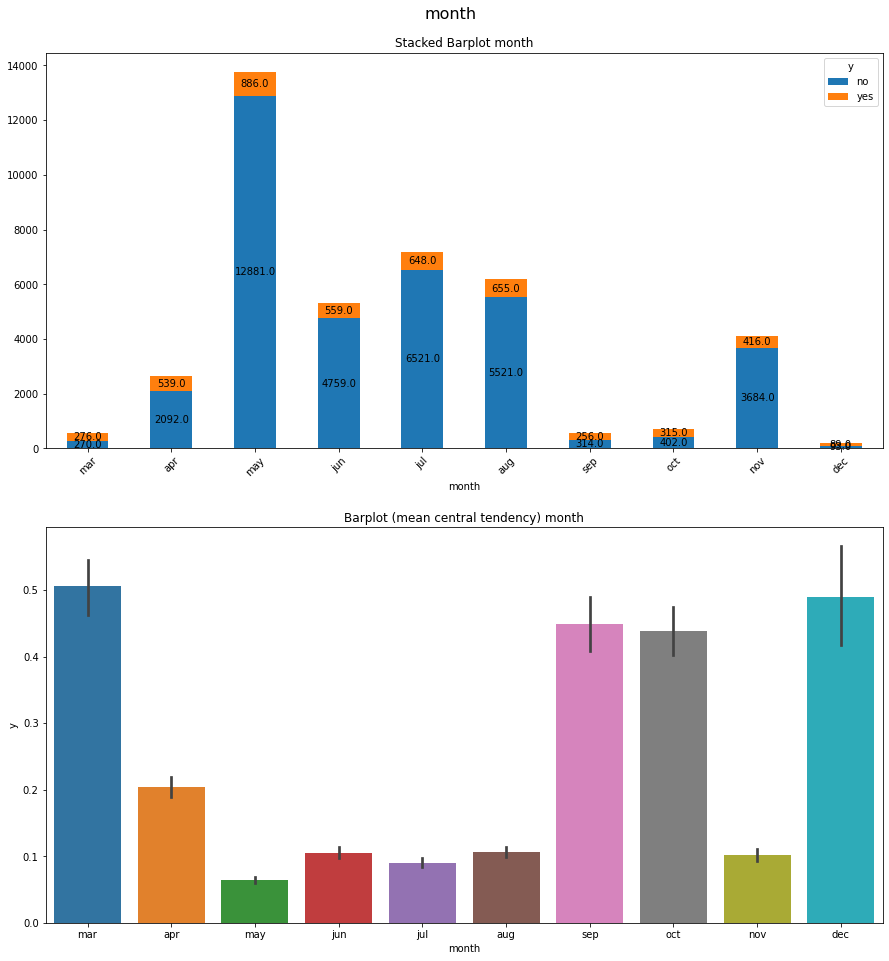

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcff6ed4518>,
      dtype=object)

In [68]:
ordered_month = ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
cat_tm_plot(bank_marketing, 'month', 'y',ordered_month)


column month menunjukkan pattern yang menarik dengan column y:

1. bar chart distribusi cenderung berkebalikan dengan bar chart central tendency. contohnya adalah bulan mei, dimana jika di bar chart distribusi menunjukkan peringkat pertama, di bar chart central tendency, menduduki peringkat terakhir atau memiliki mean paling rendah atau bisa dibilang client yang contact terakhirnya dilakukan bulan mei cenderung paling banyak tidak subscribe term deposite.
2. Error bar pada bar chart central tendency cenderung berkebalikan dengan jumlah distribusi, dimana value yang memiliki value yang kecil cenderung memiliki error bar yang tinggi, yang mana menunjukkan adanya tingkat persebaran atau variance data yang tinggi pada value tersebut. Selain itu dengan error bar yang tinggi menunjukkan kurang akuratnya mean pada value tersebut merepresentasikan mean data.
3. Terlepas dari Error bar, kita juga bisa melihat bahwa value yang memiliki distribusi yang semakin sedikit cenderung memiliki mean central tendency yang tinggi yang mana menunjukkan bahwa proporsi orang yang mensubscribe term deposite (y == 'yes') semakin besar.
4. Dengan melihat tinggi mean central tendency dan panjangnya error bar, kita bisa melihat client bulan maret, september, oktober, dan desember memiliki pattern yang mirip (mean nya sekitar 0.5 dan eror bar saling tumpang tindih) yang mana bisa kita simpulkan bahwa client yang contact terakhirnya dilakukan pada bulan tersebut (maret, september, oktober, desember) akan cenderung mensubscribe term deposite. Untuk lebih akurat kita bisa menjadikan ke empat value tersebut menjadi satu value bernama winter 

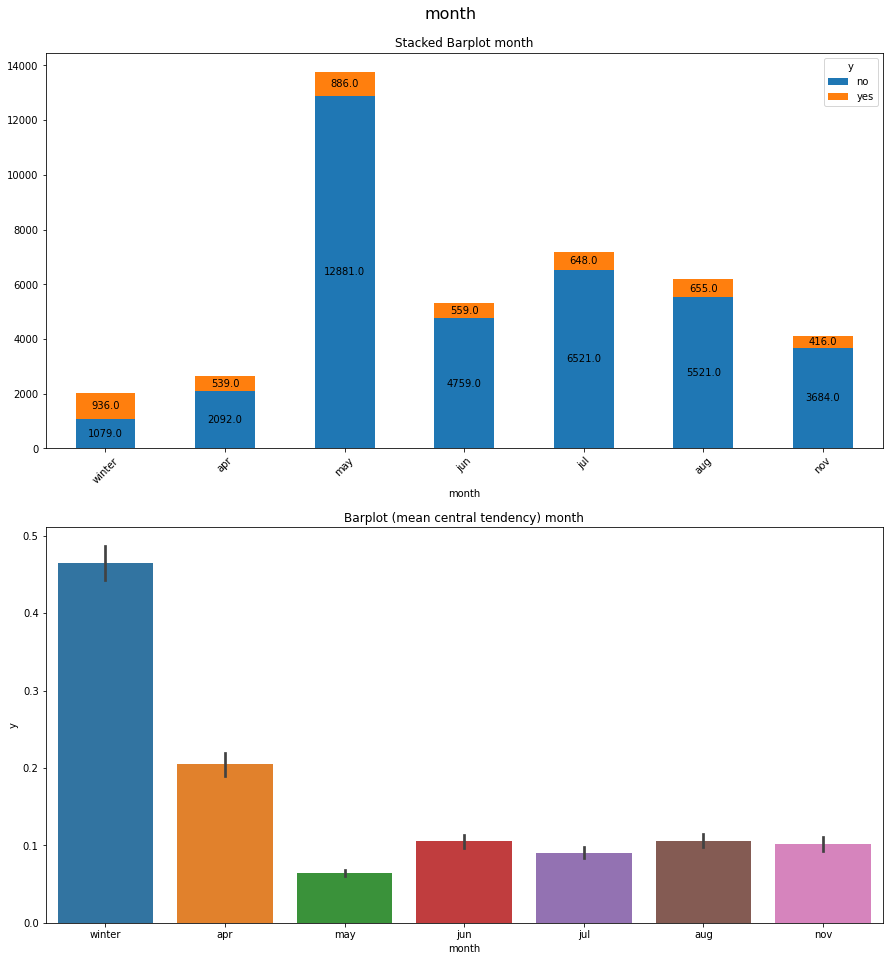

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcff6e6d940>,
      dtype=object)

In [69]:
data_month = bank_marketing.select('month','y')
l_winter = ['mar','sep','oct','dec']
data_month = data_month.withColumn('month',
                                   F.when(F.col('month').isin(l_winter),'winter')
                                   .otherwise(F.col('month')))

ordered_month = ['winter','apr','may','jun','jul','aug','nov']
cat_tm_plot(data_month, 'month', 'y',ordered_month)

terlihat bahwa error bar semakin kecil ketika menggabungkan keempat value month tersebut. dan terlihat bahwa client yang last contactnya berasal dari month winter akan cenderung mensubscribe term deposite

##### day of week

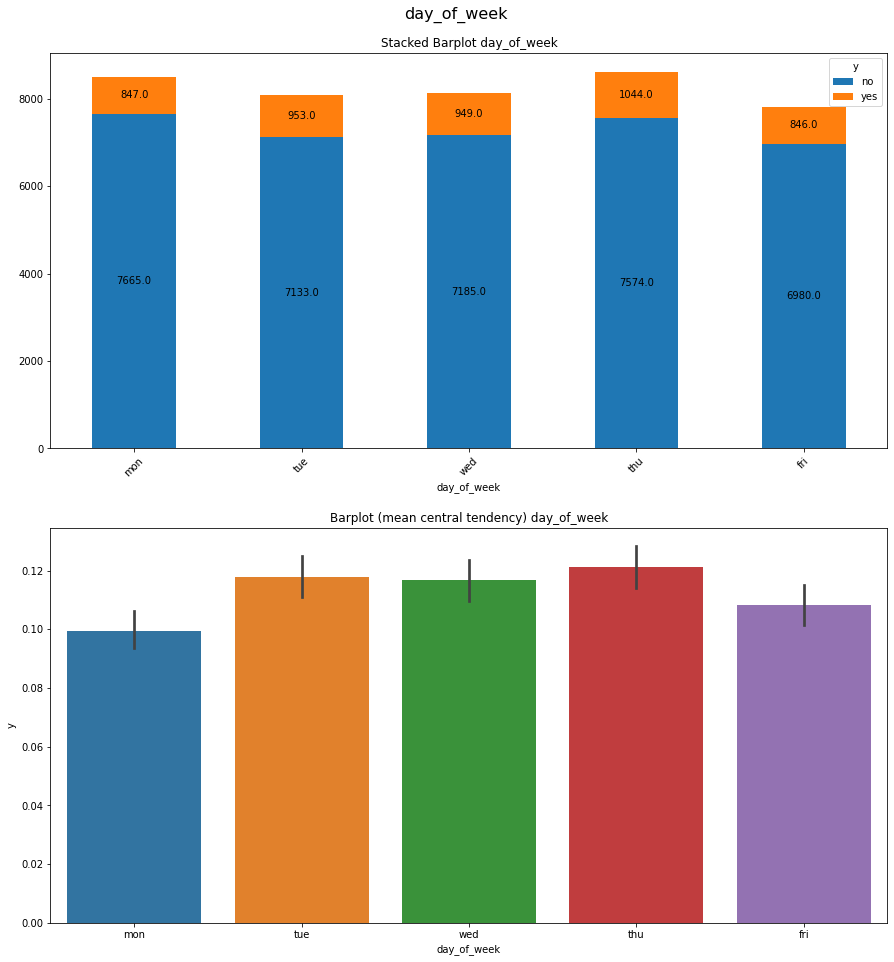

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcff6e6d7f0>,
      dtype=object)

In [70]:
ordered_day = ['mon','tue','wed','thu','fri']
cat_tm_plot(bank_marketing, 'day_of_week', 'y',ordered_day)



dari data yang didapatkan terlihat bahwa setiap value memiliki nilai mean central tendency yang hampir sama atau memiliki selisih yang tidak besar, hal ini mengindikasikan bahwa antar value memiliki proporsi nilai y yang hampir mirip, sehingga menyulitkan ketika mencari value mana yang paling berpengaruh, selain itu jika kita lihat korelasi pada theils u, terlihat bahwa column week memiliki korelasi yang rendah dengan column target('y')

In [71]:
# def stacked_barplot2(datas, columns, hue):
#   idx = '{}_{}'.format(columns, hue)
#   df_crosstab = datas.stat.crosstab(columns, hue).toPandas().set_index(idx)

#   plt.rcParams["figure.figsize"] = 15,8
#   ax =  df_crosstab.plot.bar(title= columns,stacked=True)
#   ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

#   for p in ax.patches:
#     width, height = p.get_width(), p.get_height()
#     x, y = p.get_xy() 
#     ax.text(x+width/2, 
#             y+height/2, 
#             height, 
#             horizontalalignment='center', 
#             verticalalignment='center') 

#   plt.legend(title='label')

#   plt.show()

#   return ax

#### loan,housing,y

In [72]:
# list_loan = [Row.housing for Row in bank_marketing.select('housing').distinct().collect()]
# for x in list_loan:
#   data_x = bank_marketing.filter(F.col('housing') == x)
#   print('client housing = {}'.format(x))
#   cat_plot(data_x, 'loan','y')

#### contact, month, y

In [73]:
# list_contact = [Row.contact for Row in bank_marketing.select('contact').distinct().collect()]
# for x in list_contact:
#   data_x = bank_marketing.filter(F.col('contact') == x)
#   print('client contact = {}'.format(x))
#   cat_tm_plot(data_x, 'month', 'y',ordered_month)

In [74]:
# #select data categorical
# data_cat = bank_marketing.select(text_columns)

# features_columns = [col[0] for col in data_cat.dtypes if col[1] == 'string' and col[0] != 'y']
# label_columns = 'y'

# ##label
# #label indexers
# indexer_label = StringIndexer(inputCol = 'y', outputCol = 'label')
# model_lab = indexer_label.fit(data_cat)
# data_cat = model_lab.transform(data_cat)

# ##features
# #create_indexers
# indexers = [StringIndexer(inputCol=col, outputCol = '{}_indexed'.format(col)) for col in features_columns]

# #encoders
# encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(),
#                           outputCol='{}_encoded'.format(indexer.getOutputCol()), dropLast=False) for indexer in indexers]

# #vector assembler
# assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders],
#                             outputCol = 'features')

# #create pipeline
# pipeline = Pipeline(stages=indexers + encoders + [assembler])

# #fit and transform pipeline into the data
# model_pipeline = pipeline.fit(data_cat)
# df_forChisquareTest = model_pipeline.transform(data_cat)

# from collections import OrderedDict

# idx_col = [col[0] for col in df_forChisquareTest.dtypes if '_indexed' in col[0] and '_indexed_encoded' not in col[0]]

# list_map = OrderedDict()
# for c, c_Idx in zip(features_columns, idx_col):
#   colIdx = df_forChisquareTest.select(c,c_Idx).distinct().rdd.collectAsMap()
#   list_map.update(colIdx)

# list_map.pop('yes')
# list_map.pop('no')

# aa = df_forChisquareTest.select('features','label')

# from pyspark.mllib.linalg import Vectors
# from pyspark.mllib.regression import LabeledPoint
# from pyspark.mllib.stat import Statistics

# to_labeled_point = lambda x: LabeledPoint(x[0], Vectors.dense(x[1].toArray()))
# obs = (
#     aa
#     .select('label', 'features')
#     .rdd
#     .map(to_labeled_point)
# )

# dfs = spark.createDataFrame(obs, ["label", "features"])
# dfs.selectshow()

# feature_test_results = Statistics.chiSqTest(obs)


# data = []

# for idx, result in enumerate(feature_test_results):
#     row = {
#         'feature_index': idx,
#         'p_value': result.pValue,
#         'statistic': result.statistic,
#         'degrees_of_freedom': result.degreesOfFreedom
#     }
#     data.append(row)


## Feature Engineering

### Columns Engineering



#### Campaign

handle outlier dengan merubah value campaign diatas 95 percentile dengan median data

+------------------+------------------+
|skewness(campaign)|kurtosis(campaign)|
+------------------+------------------+
| 1.517646164844036| 2.001852035875376|
+------------------+------------------+



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(None, <matplotlib.axes._subplots.AxesSubplot at 0x7fcff6ebff28>)

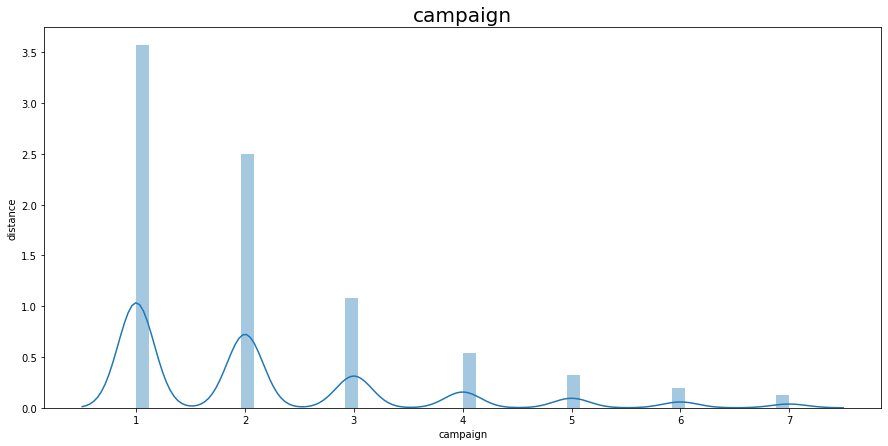

In [75]:
#replace data above 95 percentile
threshold = np.percentile(bank_marketing2.select('campaign').collect(), 95)
median = np.percentile(bank_marketing2.select('campaign').collect(), 50)
bank_marketing2 = bank_marketing2.withColumn('campaign', when(bank_marketing2.campaign <= threshold, bank_marketing2.campaign).otherwise(median))

#check histogram
to_hist(bank_marketing2, 'campaign')

#### Pdays and Previous

column pdays dan previous dihilangkan karena memiliki tingkat persebaran yang sangat rendah (column berupa numeric namun mayoritas value dalam columns terpusat pada satu value)

In [76]:
columns_to_drop = ['pdays', 'previous']
bank_marketing2 = bank_marketing2.drop(*columns_to_drop)


bank_marketing2.show()

+---+------------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----------+------------+--------------+-------------+---------+-----------+------+
|age|         job| marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|yIndex|
+---+------------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----------+------------+--------------+-------------+---------+-----------+------+
| 42|      admin.| married|  university.degree|     no|     no| yes|telephone|  may|        mon|     262|     2.0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0|   0.0|
| 49| blue-collar| married|        high.school|unknown|     no|  no|telephone|  may|        tue|      69|     1.0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0|   0.0|
| 45| blue

#### job and marital

merubah nilai unknown dengan modus pada columns (strategi ini diambil karena ratio unknown tidak terlalu tinggi, sehingga jika merubah datanya ke modus column tidak akan mempengaruhi secara besar terhadap karakteristik informasi yang terkandung pada column)

In [77]:
bank_marketing2 = bank_marketing2.withColumn('job',
                                              when(F.col('job')=='unknown','admin.')
                                              .otherwise(F.col('job')))

bank_marketing2 = bank_marketing2.withColumn('marital',
                                              when(F.col('marital')=='unknown','married')
                                              .otherwise(F.col('marital')))

#### emp_var_rate

mentranformasi nilai emp_var_rate karena beberap algoritma tidak bisa menerima nilai negative

In [78]:
bank_marketing2.groupby('emp_var_rate').count().show()

+------------+-----+
|emp_var_rate|count|
+------------+-----+
|        -1.7|  773|
|        -0.1| 3682|
|         1.4|16228|
|        -1.8| 9182|
|        -3.0|  172|
|        -1.1|  635|
|        -2.9| 1662|
|         1.1| 7762|
|        -0.2|   10|
|        -3.4| 1070|
+------------+-----+



pada data emp_var_rate terlihat jika range data berasal dari - 3 sampai 1, karena beberapa algoritma tidak menerima nilai  negative, kita akan menambah semua value dengan 4, agar rangenya menjadi diatas 0 tanpa harus merubah susunan informasi di dalamnya

In [79]:
bank_marketing2 = bank_marketing2.withColumn('emp_var_rate', F.round(bank_marketing2.emp_var_rate + F.lit(4),2))
bank_marketing2.groupby('emp_var_rate').count().sort(F.desc('emp_var_rate')).show()

+------------+-----+
|emp_var_rate|count|
+------------+-----+
|         5.4|16228|
|         5.1| 7762|
|         3.9| 3682|
|         3.8|   10|
|         2.9|  635|
|         2.3|  773|
|         2.2| 9182|
|         1.1| 1662|
|         1.0|  172|
|         0.6| 1070|
+------------+-----+



#### cons_conf_idx

mentranformasi nilai di cons_conf_idx

In [80]:
bank_marketing2 = bank_marketing2.withColumn('cons_conf_idx', -1 * bank_marketing2.cons_conf_idx )
bank_marketing2.filter(bank_marketing2.cons_conf_idx < 0).show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+--------+------------+--------------+-------------+---------+-----------+------+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|yIndex|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+--------+------------+--------------+-------------+---------+-----------+------+
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+--------+------------+--------------+-------------+---------+-----------+------+



#### housing and loan

house dan loan dihapus karena pada uji korelasi dan investigasi visualisasi menunjukkan house dan loan kurang berpengaruh terhadap column target

In [81]:
bank_marketing2 = bank_marketing2.drop('housing','loan')

#### Education

beberapa tahap feature engineering pada column education:
1. menghapus row yang memiliki nilai illiterate karena hanya 9 row yang memiliki nilai illiterate
2. merubah unknown value dengan modus column
3. merubah nilai column education dengan numeric berdasarkan urutan pendidikannya (data ordinal)

In [82]:
#remove row contain illiterate
bank_marketing2 = bank_marketing2.filter(F.col('education') != 'illiterate')

#change unknown value with modus of the data
groupby_ed = bank_marketing2.groupBy('education').count()
mode_col = groupby_ed.sort(F.col('count').desc()).collect()[0][0]

bank_marketing2 = bank_marketing2.withColumn('education',
                                             when(F.col('education') == 'unknown',mode_col)
                                             .otherwise(F.col('education')))

# mapping education
ordered_education = ['basic.4y','basic.6y','basic.9y','high.school','professional.course','university.degree']
dict_education = {}

for i in ordered_education:
  dict_education[i] = ordered_education.index(i)

#create udf function
edu_func = F.udf(lambda x: dict_education.get(x), IntegerType())
bank_marketing2 = bank_marketing2.withColumn('num_education', edu_func(F.col('education')))

bank_marketing2 = bank_marketing2.drop('education')


#### month

pada tahap EDA terlihat beberapa value month memiliki central tendency yang sama column target sehingga leboh baik menjadikan beberapa value tersebut menjadi satu value

In [83]:
l_winter = ['mar','sep','oct','dec']
bank_marketing2 = bank_marketing2.withColumn('month',
                                             F.when(F.col('month').isin(l_winter),'winter')
                                             .otherwise(F.col('month')))

#### target encoding

In [84]:

# def target_mean_encoding(df, col, target):
#     """
#     :param df: pyspark.sql.dataframe
#         dataframe to apply target mean encoding
#     :param col: str list
#         list of columns to apply target encoding
#     :param target: str
#         target column
#     :return:
#         dataframe with target encoded columns
#     """
#     target_encoded_columns_list = []
#     for c in col:
#         means = df.groupby(F.col(c)).agg(F.mean(target).alias(f"{c}_mean_encoding"))
#         dict_means = means.toPandas().set_index(c).to_dict()[f"{c}_mean_encoding"]
#         target_encoded_columns = [F.when(F.col(c) == v, encoder)
#                                   for v, encoder in zip(dict_means.keys(),
#                                                         dict_means.values())]
#         target_encoded_columns_list.append(F.coalesce(*target_encoded_columns).alias(f"{c}_mean_encoding"))

#     num_col = [c[0] for c in df.dtypes if c[0] not in col and c[0] != target]
#     ssh = target_encoded_columns_list + num_col

#     return df.select(target, *ssh)


# bank_marketing2 = target_mean_encoding(bank_marketing2, col=['month','day_of_week'], target='yIndex')


### One hot Encoding / Get Dummy

encoding column categorical

In [85]:
#get numeric and categorical columns
text_columns = [col[0] for col in bank_marketing2.dtypes if col[1].startswith('string')]
numeric_columns = [col[0] for col in bank_marketing2.dtypes if col[1] != 'string' and col[0] != 'yIndex']

#create_indexers
indexers = [StringIndexer(inputCol=col, outputCol = '{}_indexed'.format(col)) for col in text_columns]

#encoders
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(),
                          outputCol='{}_encoded'.format(indexer.getOutputCol()), dropLast=False) for indexer in indexers]

#vector assembler
assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders] + numeric_columns,
                            outputCol = 'features')

#create pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])

#fit and transform pipeline into the data
model = pipeline.fit(bank_marketing2)
new_bank_marketing = model.transform(bank_marketing2)

#create columns label
new_bank_marketing = new_bank_marketing.withColumn('label', F.col('yIndex'))

#select only features and labels
new_bank_marketing = new_bank_marketing.select('features','label')

new_bank_marketing.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(43,[0,11,14,18,1...|  0.0|
|(43,[1,11,15,18,1...|  0.0|
|(43,[1,12,14,18,1...|  0.0|
|(43,[4,12,14,18,1...|  0.0|
|(43,[3,13,14,18,1...|  0.0|
|(43,[1,13,14,18,1...|  0.0|
|(43,[2,11,14,18,1...|  0.0|
|(43,[3,11,14,18,1...|  0.0|
|(43,[1,11,15,18,1...|  0.0|
|(43,[1,11,14,18,1...|  0.0|
|(43,[10,12,15,18,...|  0.0|
|(43,[6,11,15,18,1...|  0.0|
|(43,[1,13,14,18,1...|  0.0|
|(43,[1,12,15,18,1...|  0.0|
|(43,[1,11,14,18,1...|  0.0|
|(43,[1,11,15,18,1...|  0.0|
|(43,[3,11,15,18,1...|  0.0|
|(43,[0,13,14,18,1...|  0.0|
|(43,[4,11,14,18,1...|  0.0|
|(43,[3,11,15,18,1...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [86]:
new_bank_marketing.select('features').show(10, truncate = False)

+-----------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                           |
+-----------------------------------------------------------------------------------------------------------------------------------+
|(43,[0,11,14,18,19,27,31,34,35,36,37,38,39,40,41,42],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,42.0,262.0,2.0,5.1,93.994,36.4,4.857,5191.0,5.0])|
|(43,[1,11,15,18,19,29,31,34,35,36,37,38,39,40,41,42],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,49.0,69.0,1.0,5.1,93.994,36.4,4.857,5191.0,3.0]) |
|(43,[1,12,14,18,19,28,31,34,35,36,37,38,39,40,41,42],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,45.0,129.0,5.0,5.1,93.994,36.4,4.856,5191.0,1.0])|
|(43,[4,12,14,18,19,26,31,34,35,36,37,38,39,40,41,42],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,45.0,477.0,2.0,5.1,93.994,36.4,4.855,5191.0,5.0])|
|(43,[3,13,14,18,19,30,31,34,35,36,37,38,39,40,41,42],[1.0,1.0

### Standarization

robust scaler dipilih karena lebih robust terhadap outliers

In [87]:
#Robustscaler
from pyspark.ml.feature import RobustScaler
scaler = RobustScaler(inputCol='features', outputCol='new_features')

new_bank_marketing = scaler.fit((new_bank_marketing)).transform(new_bank_marketing)

new_bank_marketing.select('new_features').show(10, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|new_features                                                                                                                                                                                                                      |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(43,[0,11,14,18,19,27,31,34,35,36,37,38,39,40,41,42],[1.0,1.0,0.0,1.0,1.0,0.0,0.0,2.8,1.2129629629629628,1.0,1.59375,102.27856365614834,5.777777777777773,1.3428255460326237,40.24031007751938,1.6666666666666665])               |
|(43,[1,11,15,18,19,29,31,34,35,36,37,38,39,40,41,42],[0.0,1.0,0.0,1.0,1.0,0.0,0.0,3

### Normalization

In [88]:

normalizer = Normalizer(inputCol='new_features', outputCol='features_norm1', p=1.0)

new_bank_marketing = normalizer.transform(new_bank_marketing)

new_bank_marketing.select('features_norm1').show(10, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features_norm1                                                                                                                                                                                                                                                                                                                                  |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Final dataset

In [89]:
final_df = new_bank_marketing.select('features_norm1', 'label')
final_df.show(5, False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features_norm1                                                                                                                                                                                                                                                                                                                                  |label|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Classification

### Split the data

In [90]:
(trainingData, testData) = final_df.randomSplit([0.8, 0.2])

trainingData.count()
trainingData.show(5, False)

testData.count()
testData.show(5,False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features_norm1                                                                                                                                                                                                                                                                                                                                    |label|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Baseline model Logistic Regression

#### fit and make pipeline

In [91]:
%%time

logreg = LogisticRegression(featuresCol='features_norm1', labelCol='label')

model = logreg.fit(trainingData)

CPU times: user 1.55 s, sys: 672 ms, total: 2.23 s
Wall time: 2min 9s


#### Predictions

In [92]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|      features_norm1|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(43,[0,11,14,17,1...|  0.0|[3.47560546059538...|[0.96998564370136...|       0.0|
|(43,[0,11,14,17,2...|  0.0|[3.84057593974450...|[0.97897051326498...|       0.0|
|(43,[0,12,14,17,2...|  0.0|[0.42606778995860...|[0.60493430311876...|       0.0|
|(43,[0,12,14,17,2...|  1.0|[0.34714886667454...|[0.58592601619438...|       0.0|
|(43,[0,13,14,17,2...|  0.0|[4.32863939195908...|[0.98698611865944...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



#### Evaluations

In [93]:
BasepredictionAndLabels = predictions.select(['prediction', 'label']\
                                        ).withColumn('label',F.col('label').cast(DoubleType())).rdd
  
metrics = BinaryClassificationMetrics(BasepredictionAndLabels)
metrics2 = MulticlassMetrics(BasepredictionAndLabels)
# Overall statistics
precision = metrics2.precision(1.0)
recall = metrics2.recall(1.0)
f1Score = metrics2.fMeasure(1.0)
area_underROC = metrics.areaUnderROC

print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)
print('area under ROC = %g' % area_underROC)

Summary Stats
Precision = 0.6191446028513238
Recall = 0.34902411021814006
F1 Score = 0.4464023494860499
area under ROC = 0.661567


karena data target memiliki kondisi imbalance maka lebih baik menggunakan AUC ROC precision dan recall untuk mengevaluasi model machine learning.

dari hasil baseline diatas terlihat kita hanya mendapatkan nilai AUR ROC 0.67 yang mana menunjukkan model kita masih jatuh ke error 1 dan error 2

#### Handling imbalance target using balance ratio

untuk mengatasinya, cara pertama dengan menambah weight atau bobot pada logistic regression berdasarkan jumlah unique value di column target

In [94]:
label_0 = final_df.filter(final_df.label == 0).count() / final_df.count() * 100
label_1 = final_df.filter(final_df.label == 1).count()/ final_df.count() * 100

print('label_0 = {} %'.format(label_0))
print('label_1 = {} %'.format(label_1))

label_0 = 88.73851985033286 %
label_1 = 11.261480149667136 %


kita mendapatkan informasi bahwa 88 persen column target memiliki nilai no(label 0), sedangkan 11 persen memiliki nilai yes (label 1). Karena mayoritas memiliki nilai no maka fungsi logistic loss harus memperlakukan nilai yes dengan bobot yang lebih tinggi. Untuk tujuan ini, kita bisa menghitung balancing ratio:

BalancingRatio= numNegatives/dataset_size

sehingga setiap keluaran == yes, kita memasukkan 'balancing ratio' ke dalam "class weight" sedanglan setiap keluaran == no kita memasukkan '1- balancing ratio' ke 'class weight'

dengan memberikan weight lebih besar kepada minoritas value (value == 'yes') dan lebih kecil ke moyitas value (value == 'no'), algoritma  atau model akan lebih fokus kepada nilai minoritas sehingga akan mendapatkan hasil prediksi yang lebih akurat


In [95]:
BalancingRatio= final_df.filter(final_df.label == 0).count() / final_df.count()
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.8873851985033286


In [96]:
#create columns balance ratio in train dataset
trainingData = trainingData.withColumn("classWeights", when(trainingData.label == 1, BalancingRatio).otherwise(1-BalancingRatio))
trainingData.show()


+--------------------+-----+-------------------+
|      features_norm1|label|       classWeights|
+--------------------+-----+-------------------+
|(43,[0,11,14,17,1...|  0.0|0.11261480149667136|
|(43,[0,11,14,17,1...|  0.0|0.11261480149667136|
|(43,[0,11,14,17,1...|  0.0|0.11261480149667136|
|(43,[0,11,14,17,1...|  0.0|0.11261480149667136|
|(43,[0,11,14,17,1...|  0.0|0.11261480149667136|
|(43,[0,11,14,17,2...|  0.0|0.11261480149667136|
|(43,[0,11,14,17,2...|  0.0|0.11261480149667136|
|(43,[0,11,14,17,2...|  0.0|0.11261480149667136|
|(43,[0,11,14,17,2...|  0.0|0.11261480149667136|
|(43,[0,11,14,17,2...|  0.0|0.11261480149667136|
|(43,[0,11,14,17,2...|  0.0|0.11261480149667136|
|(43,[0,11,14,17,2...|  0.0|0.11261480149667136|
|(43,[0,11,14,18,1...|  0.0|0.11261480149667136|
|(43,[0,11,14,18,1...|  0.0|0.11261480149667136|
|(43,[0,11,14,18,1...|  0.0|0.11261480149667136|
|(43,[0,11,14,18,1...|  0.0|0.11261480149667136|
|(43,[0,11,14,18,2...|  0.0|0.11261480149667136|
|(43,[0,11,14,18,2..

#### predictions

In [97]:
%%time

#building classifications
logreg1 = LogisticRegression(featuresCol='features_norm1', labelCol='label', weightCol="classWeights")

model1 = logreg1.fit(trainingData)

# Make predictions.
predictions1 = model1.transform(testData)
# Select example rows to display.
predictions1.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|      features_norm1|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(43,[0,11,14,17,1...|  0.0|[2.22965933117147...|[0.90288149105449...|       0.0|
|(43,[0,11,14,17,2...|  0.0|[2.67969131151989...|[0.93581758532280...|       0.0|
|(43,[0,12,14,17,2...|  0.0|[-1.6241538112592...|[0.16463280523341...|       1.0|
|(43,[0,12,14,17,2...|  1.0|[-1.7236129480876...|[0.15140637823272...|       1.0|
|(43,[0,13,14,17,2...|  0.0|[3.27688560523242...|[0.96362728236603...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows

CPU times: user 1.43 s, sys: 687 ms, total: 2.12 s
Wall time: 2min 1s


#### ROC AUC plot for Training

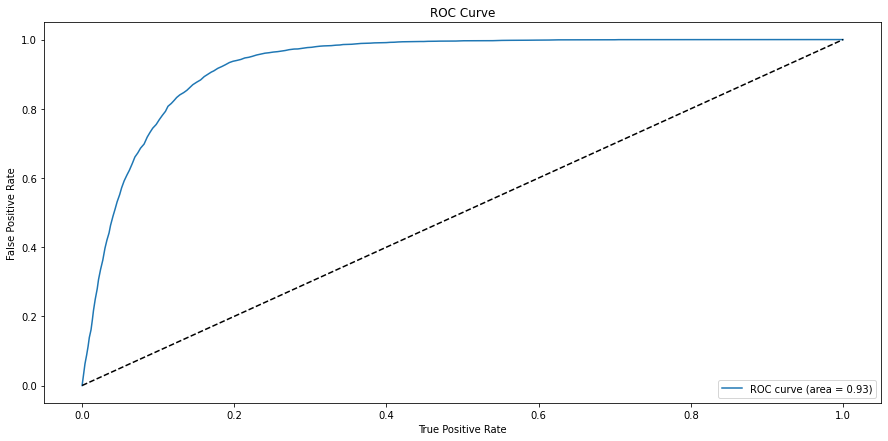

In [98]:
trainingSummary = model1.summary
df_roc = trainingSummary.roc.toPandas()

plt.figure(figsize=(15,7))
plt.plot(df_roc['FPR'],df_roc['TPR'], label='ROC curve (area = %0.2f)' % trainingSummary.areaUnderROC)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


kita mendapatkan roc auc diatas 90 %

#### Evaluation for testData

In [99]:
BasepredictionAndLabels = predictions1.select(['prediction', 'label']\
                                        ).withColumn('label',F.col('label').cast(DoubleType())).rdd
  
metrics = BinaryClassificationMetrics(BasepredictionAndLabels)
metrics2 = MulticlassMetrics(BasepredictionAndLabels)
# Overall statistics
precision = metrics2.precision(1.0)
recall = metrics2.recall(1.0)
f1Score = metrics2.fMeasure(1.0)
area_underROC = metrics.areaUnderROC

print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)
print('area under ROC = %g' % area_underROC)

Summary Stats
Precision = 0.4038876889848812
Recall = 0.8587830080367393
F1 Score = 0.5493940506793976
area under ROC = 0.852969


terlihat peningkatan nilai ROC AUC yang jauh lebih baik dari model baseline, nilai roc -auc kita naik dari 0.67 menjadi 0.86 setelah melakukan 'weight balancing'

#### ROC-AUC for test

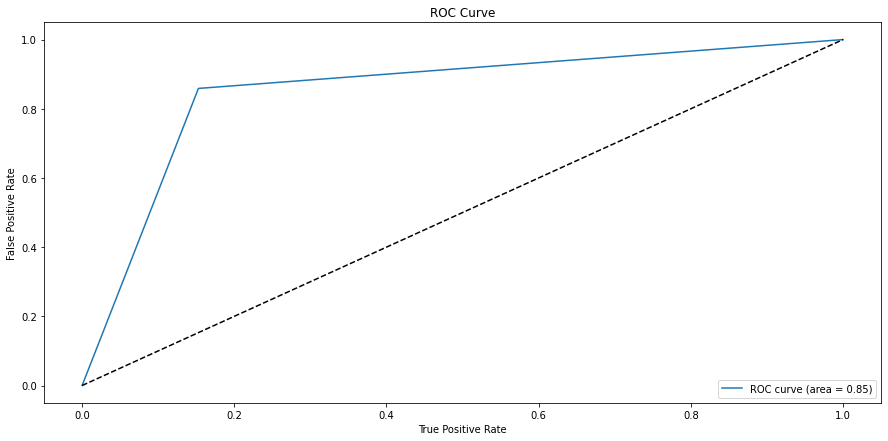

In [100]:
#Visualization
df_predictions = predictions1.select('label', 'prediction').toPandas()
fpr, tpr, thresholds = roc_curve(df_predictions['label'], df_predictions['prediction'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15,7))
plt.plot(fpr,tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

terlihat dari visualisasi diatas didapatkan nilai ROC AUC sebesar 0.86

Hasil diatas merupakan hasil logistic regression yang belum memiliki hyperparameter yang lengkap aliasa masih menggunakan default hyperparameter yang diprovide oleh pyspark mlib, untuk mencari nilai hyperparameter yang maksimum(dan arti memberikan nilai ROC AUC) yang lebih tinggi kita bisa menggunakan code dibawah untuk melakukan random search dan croosvalidation 

In [101]:
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# logreg1 = LogisticRegression(featuresCol='features_norm1', labelCol='label', weightCol="classWeights")
# roc_eval = BinaryClassificationEvaluator(
#      rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC'
# )

# #create parametergrid
# paramGrid = ParamGridBuilder() \
#     .addGrid(logreg1.aggregationDepth, [2,5,10]) \
#     .addGrid(logreg1.elasticNetParam, [0.0, 0.5, 1.0]) \
#     .addGrid(logreg1.fitIntercept, [False, True]) \
#     .addGrid(logreg1.maxIter,[10, 100, 1000]) \
#     .addGrid(logreg1.regParam, [0.01, 0.5, 2.0]) \
#     .build()

# #k fold cross val
# cv = CrossValidator(estimator=logreg1, evaluator=roc_eval, numFolds=10)

# cvmodel = cv.fit(trainingData)



### Secondary Model using weight balance

#### Test on another model

In [108]:
def fit_model(models):
  model_learn = models(featuresCol='features_norm1', labelCol='label', weightCol="classWeights")
  fitmodel = model_learn.fit(trainingData)

  result = fitmodel.transform(testData)

  predictionAndLabels = result.select(['prediction', 'label']\
                                      ).withColumn('label',F.col('label').cast(DoubleType())).rdd
  
  metrics = MulticlassMetrics(predictionAndLabels)
  metrics2 = BinaryClassificationMetrics(predictionAndLabels)

  # Overall statistics
  precision = metrics.precision(1.0)
  recall = metrics.recall(1.0)
  f1Score = metrics.fMeasure(1.0)
  area_underROC = metrics2.areaUnderROC

  ss = [precision, recall, f1Score, area_underROC]
  return ss

Nbayes = fit_model(NaiveBayes)
DecTree = fit_model(DecisionTreeClassifier)
RandomForest = fit_model(RandomForestClassifier)
gbt = fit_model(GBTClassifier)


print("Naivebayes: precision, recall, f1score, area_underROC ", Nbayes)
print("DecisionTree: precision, recall, f1score, area_underROC ", DecTree)
print("RandomForest: precision, recall, f1score, area_underROC ", RandomForest)
print("GBT: precision, recall, f1score, area_underROC ", gbt)



Naivebayes: precision, recall, f1score, area_underROC  [0.13521082931383227, 0.9977037887485649, 0.2381474376541518, 0.6141087128707521]
DecisionTree: precision, recall, f1score, area_underROC  [0.3629730962152303, 0.9138920780711826, 0.5195822454308094, 0.8602410688016165]
RandomForest: precision, recall, f1score, area_underROC  [0.36020036429872493, 0.9081515499425947, 0.5158134985327681, 0.8568170182220242]
GBT: precision, recall, f1score, area_underROC  [0.40706605222734255, 0.912743972445465, 0.5630311614730878, 0.8762113881332959]


melihat hasil diatas kita bisa menyimpulkan GBT dan decisionTree merupakan  model yang potential untuk kasus data ini, dimana decisionTree : 0.86 dan GBT: 0.88

#### Decision Tree

In [109]:
%%time
from pyspark.ml.classification import DecisionTreeClassifier


#building classifications
DTree = DecisionTreeClassifier(featuresCol='features_norm1', labelCol='label',
                               maxDepth=30, minInstancesPerNode=50,
                               seed=42, weightCol="classWeights")

DtreeModel = DTree.fit(trainingData)

# Make predictions.
Rpredictions = DtreeModel.transform(testData)

BasepredictionAndLabels = Rpredictions.select(['prediction', 'label']\
                                              ).withColumn('label',F.col('label').cast(DoubleType())).rdd
  
metrics = BinaryClassificationMetrics(BasepredictionAndLabels)
metrics2 = MulticlassMetrics(BasepredictionAndLabels)
# Overall statistics
precision = metrics2.precision(1.0)
recall = metrics2.recall(1.0)
f1Score = metrics2.fMeasure(1.0)
area_underROC = metrics.areaUnderROC

print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)
print('area under ROC = %g' % area_underROC)

Summary Stats
Precision = 0.3943803311590567
Recall = 0.9024110218140069
F1 Score = 0.5488826815642459
area under ROC = 0.867653
CPU times: user 277 ms, sys: 110 ms, total: 387 ms
Wall time: 1min 4s


dengan sedikit melakukan modifikasi di hyperparametenya, kita mendapatkan roc_auc 0.87

##### Model validation

Kita bisa menvalidasi model menggunakan confussion matrix

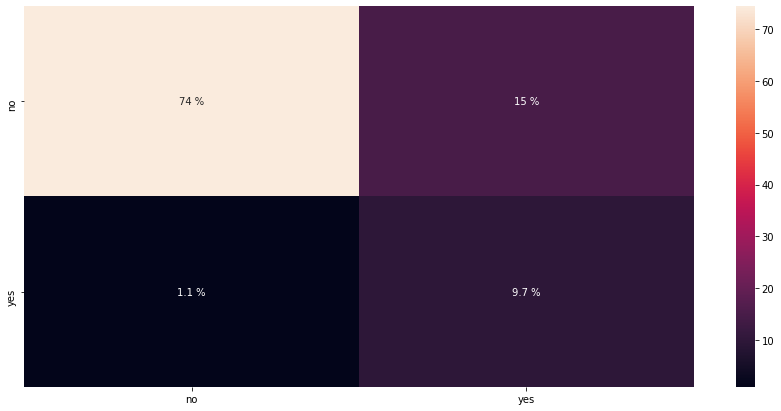

In [110]:

y_true = Rpredictions.select("label")
y_true = y_true.toPandas()

y_pred = Rpredictions.select("prediction")
y_pred = y_pred.toPandas()

conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix = pd.DataFrame(conf_matrix) / len(y_true) * 100

columns = ['no', 'yes']

conf_matrix.index, conf_matrix.columns = columns, columns

plt.figure(figsize=(15,7))
ax = sns.heatmap(conf_matrix, annot=True, fmt='.2g')
for t in ax.texts:
  t.set_text(t.get_text() + " %")
  
plt.show()

terlihat bahwa menggunakan decision tree, kita berhasil secara tepat true positif sebesar 74 % dari data, dan memprediksi secara tepat true negative sebesar 9.7 % dari data, sedangkan 16,1 % berasal dari false positif dan false negative

dan kita mendapat 88 % auc roc

### Oversampling

Selain menggunakan weight balance , kita bisa melakukan oversampling untuk mengatasi data imbalance pada column target.


In [127]:
#split the data
(over_train_df, over_test_df) = new_bank_marketing.randomSplit([0.8, 0.2])

print('train_df')
print(over_train_df.count())
over_train_df.show(5)

print('test_df')
print(over_test_df.count())
over_test_df.show(5)

train_df
32969
+--------------------+-----+--------------------+--------------------+
|            features|label|        new_features|      features_norm1|
+--------------------+-----+--------------------+--------------------+
|(43,[0,11,14,17,1...|  0.0|(43,[0,11,14,17,1...|(43,[0,11,14,17,1...|
|(43,[0,11,14,17,1...|  0.0|(43,[0,11,14,17,1...|(43,[0,11,14,17,1...|
|(43,[0,11,14,17,1...|  0.0|(43,[0,11,14,17,1...|(43,[0,11,14,17,1...|
|(43,[0,11,14,17,1...|  0.0|(43,[0,11,14,17,1...|(43,[0,11,14,17,1...|
|(43,[0,11,14,17,2...|  0.0|(43,[0,11,14,17,2...|(43,[0,11,14,17,2...|
+--------------------+-----+--------------------+--------------------+
only showing top 5 rows

test_df
8189
+--------------------+-----+--------------------+--------------------+
|            features|label|        new_features|      features_norm1|
+--------------------+-----+--------------------+--------------------+
|(43,[0,11,14,17,1...|  0.0|(43,[0,11,14,17,1...|(43,[0,11,14,17,1...|
|(43,[0,11,14,17,1...|  

#### Decision Tree on oversampling dataset


oversampling training set

In [128]:
major_df = over_train_df.filter(F.col('label') == 0.0)
minor_df = over_train_df.filter(F.col('label') == 1.0)

ratio = int(major_df.count()/ minor_df.count())

print('data has ratio {}'.format(ratio))

#oversampling 
#membuat array yang berisi nilai dari range ratio
#explode setiap value di minor_df menggunakan array
#contohnya jika range_ratio = 7, maka kita punya array (0,6) (total=7), 
#sehingga kalikan setiap row pada minor_df sebanyak 7 kali

range_ratio = range(ratio)
oversample_df = minor_df.withColumn('dummy', F.explode(F.array([F.lit(x) for x in range_ratio]))).drop('dummy')

#combine oversample with major df
combine_OverTrainDf = major_df.unionAll(oversample_df)
combine_OverTrainDf.show()


data has ratio 7
+--------------------+-----+--------------------+--------------------+
|            features|label|        new_features|      features_norm1|
+--------------------+-----+--------------------+--------------------+
|(43,[0,11,14,17,1...|  0.0|(43,[0,11,14,17,1...|(43,[0,11,14,17,1...|
|(43,[0,11,14,17,1...|  0.0|(43,[0,11,14,17,1...|(43,[0,11,14,17,1...|
|(43,[0,11,14,17,1...|  0.0|(43,[0,11,14,17,1...|(43,[0,11,14,17,1...|
|(43,[0,11,14,17,1...|  0.0|(43,[0,11,14,17,1...|(43,[0,11,14,17,1...|
|(43,[0,11,14,17,2...|  0.0|(43,[0,11,14,17,2...|(43,[0,11,14,17,2...|
|(43,[0,11,14,17,2...|  0.0|(43,[0,11,14,17,2...|(43,[0,11,14,17,2...|
|(43,[0,11,14,17,2...|  0.0|(43,[0,11,14,17,2...|(43,[0,11,14,17,2...|
|(43,[0,11,14,17,2...|  0.0|(43,[0,11,14,17,2...|(43,[0,11,14,17,2...|
|(43,[0,11,14,17,2...|  0.0|(43,[0,11,14,17,2...|(43,[0,11,14,17,2...|
|(43,[0,11,14,18,1...|  0.0|(43,[0,11,14,18,1...|(43,[0,11,14,18,1...|
|(43,[0,11,14,18,1...|  0.0|(43,[0,11,14,18,1...|(43,[0,11,1

In [129]:
%%time
from pyspark.ml.classification import DecisionTreeClassifier


#building classifications
DTree = DecisionTreeClassifier(featuresCol='features_norm1', labelCol='label',
                               maxDepth=30, minInstancesPerNode=50,
                               seed=42)

DtreeModel = DTree.fit(combine_OverTrainDf)

# Make predictions.
Rpredictions = DtreeModel.transform(over_test_df)

BasepredictionAndLabels = Rpredictions.select(['prediction', 'label']\
                                              ).withColumn('label',F.col('label').cast(DoubleType())).rdd
  
metrics = BinaryClassificationMetrics(BasepredictionAndLabels)
metrics2 = MulticlassMetrics(BasepredictionAndLabels)
# Overall statistics
precision = metrics2.precision(1.0)
recall = metrics2.recall(1.0)
f1Score = metrics2.fMeasure(1.0)
area_underROC = metrics.areaUnderROC

print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)
print('area under ROC = %g' % area_underROC)

Summary Stats
Precision = 0.43232662192393734
Recall = 0.8665919282511211
F1 Score = 0.576865671641791
area under ROC = 0.863747
CPU times: user 575 ms, sys: 262 ms, total: 837 ms
Wall time: 3min 3s


dan kita mendapatkan auc_roc sebesar 0.86 

# Conclusion

Masih banyak hal yang dapat dieksploarasi ketika kita berpetualang di dunia data terutama mengenai kasus imbalance, seperti halnya pada project ini, kita bisa melakukan pendekatan lain untuk mendapatkan tingkat AUC ROC yang lebih baik, misal menggunakan teknik SMOTE untuk handling imbalance dataset di data training


overall, hal yang paling penting ketika melakukan project data seperti ini adalah EDA untuk menentukan feature enginnering diikuti dengan pemilihan model dan hyperparameter.

## Bibliography

1. https://towardsdatascience.com/the-most-complete-guide-to-pyspark-dataframes-2702c343b2e8#97e5 by Rahul Agawal

2. https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa by Susan Li

3. https://medium.com/@aieeshashafique/exploratory-data-analysis-using-pyspark-dataframe-in-python-bd55c02a2852 by Ayesha Syafique

4. https://towardsdatascience.com/exploratory-data-analysis-eda-with-pyspark-on-databricks-e8d6529626b1 by Cao Yi

5. https://medium.com/@connectwithghosh/basic-data-preparation-in-pyspark-capping-normalizing-and-scaling-252ee7acba7d by Soumnya Gosh

6. https://runawayhorse001.github.io/LearningApacheSpark/preface.html by ChenFeng

7. https://towardsdatascience.com/the-eda-theoretical-guide-b7cef7653f0d by Aayush Oswal

8. https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9 by Shaked Zychlinski

9. https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365 by outside two standard deviation

10. https://medium.com/@junwan01/oversampling-and-undersampling-with-pyspark-5dbc25cdf253 by Jun Wan